# Import

In [10]:
import librosa
import librosa.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from pydub import AudioSegment
import os
import math
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import csv
import japanize_matplotlib


OSError: cannot load library '/opt/homebrew/lib/python3.9/site-packages/_soundfile_data/libsndfile.dylib': dlopen(/opt/homebrew/lib/python3.9/site-packages/_soundfile_data/libsndfile.dylib, 0x0002): tried: '/opt/homebrew/lib/python3.9/site-packages/_soundfile_data/libsndfile.dylib' (no such file)

In [8]:
music_count_length = 96  # UWW: 96  toshi: 90
music_half_count_length = music_count_length * 2
music_quarter_count_length = music_count_length * 4
accel_start_timing = 606  # UWW: 606  toshi: 641
kinect_start_timing = 250   # UWW: 250   toshi: 556
offset=10 # UWW: 10  toshi: 140
duration=65  # UWW: 65  toshi: 60

# music_count_length = 90  # UWW: 96  toshi: 90
# music_half_count_length = music_count_length * 2
# music_quarter_count_length = music_count_length * 4
# accel_start_timing = 641  # UWW: 606  toshi: 641
# kinect_start_timing = 556   # UWW: 250   toshi: 556
# offset=140 # UWW: 10  toshi: 140
# duration=60  # UWW: 65  toshi: 60

In [3]:
# y, sr = librosa.load("faded.wav")
y, sr = librosa.load("uww2021_music.wav")
onset_env = librosa.onset.onset_strength(y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
half_count = float(30/tempo)
quarter_count = float(15/tempo)
half_count_list = []
quarter_count_list = []
for i in range(music_half_count_length):
    half_count_list.append(i * half_count)
    
for l in range(music_quarter_count_length):
    quarter_count_list.append(l * quarter_count)

# Accel

In [4]:
def accel_composite(file_path):
    df = pd.read_csv(file_path, header = None, usecols=[3, 4, 5])
    df.columns = ["x", "y", "z"]
#     print(df)
    composite = []
    for i in range(len(df)):
        x_value = float(df["x"][i] ** 2)
        y_value = float(df["y"][i] ** 2)
        z_value = float(df["z"][i] ** 2)
        composite_value = math.sqrt(x_value + y_value + z_value)
        composite.append(composite_value)
    return composite[accel_start_timing:]  # 開始タイミング

# def accel_file_cut(file_path: pd.DataFrame) -> pd.DataFrame:
#     composite = accel_composite(file_path)
# #     df = pd.read_csv(file_name,header = None)
# #     df.columns = ["time", "degree"]
# #     df["time"] *= 0.2
#     for i in range(len(composite)):
#         if i >= 500 and composite[i] >= 2000:
#             start_timing = i
#             return print(start_timing)
#             break
    
#     composite = composite[start_timing:]
#     return composite

def accel_timing_move(file_path, threshold_level, small_or_large):
    composite = accel_composite(file_path)
#     accel_data["time"] *= 0.02
    accel_data = np.array(composite)
    accel_data = np.ndarray.flatten(accel_data)
    if small_or_large == "small":
        data_kind = 90 - accel_data
    elif small_or_large == "large":
        data_kind = accel_data
    peaks, _ = find_peaks(data_kind, height=threshold_level)
#     plt.plot(accel_data)
#     plt.plot(peaks, accel_data[peaks], "x")
#     plt.plot(np.zeros_like(accel_data), "--", color="gray")
#     plt.show()
    count = 0
    half_timing = []
    quarter_timing = []
    for _ in range(music_half_count_length):
        half_timing.append(0)
    for _ in range(music_quarter_count_length):
        quarter_timing.append(0)

#     timing 
    peak_time = []
    for i in peaks:
        time = float(i/50)
        peak_time.append(time)   
    for i in peak_time:
        for j in range(1, len(half_count_list)-1):
            if half_count_list[j] <= i < half_count_list[j+1]:
#                 if timing[j] == 1:
#                     continue
#                 else:
                half_timing[j] = 1
#             else:
#                 timing.insert(j, 0)
#     print(timing)
    return half_timing

# Kinect

In [5]:
names_list=["PELVIS","SPINE_NAVAL","SPINE_CHEST","NECK","CLAVICLE_LEFT","SHOULDER_LEFT","ELBOW_LEFT","WRIST_LEFT",
"HAND_LEFT","HANDTIP_LEFT","THUMB_LEFT","CLAVICLE_RIGHT","SHOULDER_RIGHT","ELBOW_RIGHT","WRIST_RIGHT","HAND_RIGHT",
"HANDTIP_RIGHT","THUMB_RIGHT","HIP_LEFT","KNEE_LEFT","ANKLE_LEFT","FOOT_LEFT","HIP_RIGHT","KNEE_RIGHT",
"ANKLE_RIGHT","FOOT_RIGHT","HEAD","NOSE","EYE_LEFT","EAR_LEFT","EYE_RIGHT","EAR_RIGHT"]

kinect_names = ["Time"]
for name in names_list:
    kinect_names.append(name + "_X")
    kinect_names.append(name + "_Y")
    kinect_names.append(name + "_Z")
kinect_names.append("")


def numpy_data(df: pd.DataFrame, body_part: str):
    numX=df[body_part + '_X'].to_numpy()
    numY=df[body_part + '_Y'].to_numpy()
    numZ=df[body_part + '_Z'].to_numpy()

    numX = np.ndarray.flatten(numX)
    numY = np.ndarray.flatten(numY)
    numZ = np.ndarray.flatten(numZ)

    num = np.stack([numX, numY, numZ], 1)
#     print(num)
#     num = np.ndarray.flatten(num)
#     print(num)
    return num


def find_cos(start, point, end):
    cos_list = []
    for i in range(len(start)):
        vec_a = start[i] - point[i]
        vec_c = end[i] - point[i]

        # コサインの計算
        length_vec_a = np.linalg.norm(vec_a)
        length_vec_c = np.linalg.norm(vec_c)
        inner_product = np.inner(vec_a, vec_c)
        cos = inner_product / (length_vec_a * length_vec_c)

        # 角度（ラジアン）の計算
        rad = np.arccos(cos)

        # 弧度法から度数法（rad ➔ 度）への変換
        degree = np.rad2deg(rad)
        
        cos_list.append(degree)
#     print(cos_list)
    return cos_list


def degree(file_name):
  # 点A,B,Cの座標（3次元座標上の場合）
  #a = np.array([0,1,2]) #この3行の座標はテスト用
  #b = np.array([10,20,30])
  #c = np.array([5,7,9])
    df = pd.read_csv(file_name, header=None, names = kinect_names)
    WRIST_RIGHT_data = numpy_data(df, "WRIST_RIGHT")
    SHOULDER_RIGHT_data = numpy_data(df, "SHOULDER_RIGHT")
    ELBOW_RIGHT_data = numpy_data(df, "ELBOW_RIGHT")
    ANKLE_RIGHT_data = numpy_data(df, "ANKLE_RIGHT")
    HIP_RIGHT_data = numpy_data(df, "HIP_RIGHT")
    KNEE_RIGHT_data = numpy_data(df, "KNEE_RIGHT")
    WRIST_LEFT_data = numpy_data(df, "WRIST_LEFT")
    SHOULDER_LEFT_data = numpy_data(df, "SHOULDER_LEFT")
    ELBOW_LEFT_data = numpy_data(df, "ELBOW_LEFT")
    ANKLE_LEFT_data = numpy_data(df, "ANKLE_LEFT")
    HIP_LEFT_data = numpy_data(df, "HIP_LEFT")
    KNEE_LEFT_data = numpy_data(df, "KNEE_LEFT")
    
#     print(WRIST_RIGHT_data,SHOULDER_RIGHT_data)
#     print(WRIST_RIGHT_data - SHOULDER_RIGHT_data)
 
    ELBOW_RIGHT_degree = find_cos(WRIST_RIGHT_data, ELBOW_RIGHT_data, SHOULDER_RIGHT_data)
    KNEE_RIGHT_degree = find_cos(ANKLE_RIGHT_data, KNEE_RIGHT_data, HIP_RIGHT_data)
    ELBOW_LEFT_degree = find_cos(WRIST_LEFT_data, ELBOW_LEFT_data, SHOULDER_LEFT_data)
    KNEE_LEFT_degree = find_cos(ANKLE_LEFT_data, KNEE_LEFT_data, HIP_LEFT_data)
  
    return ELBOW_RIGHT_degree, KNEE_RIGHT_degree, ELBOW_LEFT_degree, KNEE_LEFT_degree


def file_cut(df: pd.DataFrame) -> pd.DataFrame:
#     df = pd.read_csv(file_name,header = None)
#     df.columns = ["Degree"]
#     df["time"] *= 0.2
    count = 0
    for i in range(len(df)):
        if i > 400 and df[i] >= 30:
            start_timing = i
            break
#     print(i)
    df = df[start_timing+1:]
    return df

# def decide_threshold_level()

def kinect_timing_move(accel_data, threshold_level, small_or_large):
#     accel_data = file_cut(df)
#     accel_data["time"] *= 0.02
    accel_data = accel_data[kinect_start_timing:]   # 開始タイミング
#     print(accel_data)
    if small_or_large == "small":
        data_kind = 90 - accel_data
    elif small_or_large == "large":
        data_kind = accel_data
    peaks, _ = find_peaks(data_kind, height=threshold_level)
#     plt.plot(accel_data)
#     plt.plot(int(peaks), accel_data[peaks], "x")
#     plt.plot(np.zeros_like(accel_data), "--", color="gray")
#     plt.show()
#     print(float(peaks[0]/20))
#     feature_datalist = []
#     for i in range(len(accel_data)):
# #         print(i)
#         if peaks.size != 0:
#             if i == peaks[0]:
#                 count += 1
#                 feature_datalist.insert(i,1)
#                 peaks = peaks[1:len(peaks)]
#             else:
#                 feature_datalist.insert(i,0)
                
#     for j in range(len(accel_data)):
#         for i in range(len(count_list)):
#             if peaks.size != 0:
#     #             print(count_list[i])
#                 if j == peaks[0]:
#                     peak_time = float(j/20)
#                     print(peak_time)
#                     if count_list[i] <= peak_time < count_list[i+1]:
#         #                 print(peaks[0])
#                         feature_datalist.insert(i,1)
#                     else:
#                         feature_datalist.insert(i,0)
#         peaks = peaks[1:len(peaks)]
#     print(feature_datalist)
    count = 0
    half_timing = []
    quarter_timing = []
    for _ in range(music_half_count_length):
        half_timing.append(0)
    for _ in range(music_quarter_count_length):
        quarter_timing.append(0)

#     timing 
    peak_time = []
    for i in peaks:
        time = float(i/30)
        peak_time.append(time)   
    for i in peak_time:
        for j in range(1, len(half_count_list)-1):
            if half_count_list[j] <= i < half_count_list[j+1]:
#                 if timing[j] == 1:
#                     continue
#                 else:
                half_timing[j] = 1
#             else:
#                 timing.insert(j, 0)
#     print(timing)
    return half_timing

# Onset

In [6]:
def onset_timing(file_name, music_part, threshold):

    mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.ymargin'] = 0

    y, sr = librosa.load(music_part, sr=16000, mono=True, offset=offset, duration=duration)  # 演奏時間

    o_env = librosa.onset.onset_strength(y, sr=sr)**threshold  #基準値を設定 
    times = librosa.times_like(o_env, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

    onset_time = np.round(times[onset_frames],decimals=2)

    half_timing = []
    quarter_timing = []
    for _ in range(music_half_count_length):
        half_timing.append(0)
    for _ in range(music_quarter_count_length):
        quarter_timing.append(0)

#     timing 
#     peak_time = []
    for i in onset_time:
        for j in range(1, len(half_count_list)-1):
            if half_count_list[j] <= i < half_count_list[j+1]:
#                 if timing[j] == 1:
#                     continue
#                 else:
                half_timing[j] = 1
#             else:
#                 timing.insert(j, 0)
#     print(timing)
    return half_timing

# Estimate

In [7]:
def enlarge_sentence(sentence: list, length: int) -> list:
    sentence_list = []
    for i in sentence:
        for _ in range(length):
            sentence_list.append(i)
    return sentence_list

def similarly_score(motion, music):
    plus_point = 1
    minus_point = 0
    score_list = []
    for i in range(len(motion)):
        if motion[i]==1 and music[i]==1:
            score_list.append(plus_point)
        elif motion[i]==0 and music[i]==0:
            score_list.append(0)
        elif motion[i] != music[i]:
            score_list.append(0)
    return score_list 

def similary_press_score(motion, music, length):
    score_sentence = similarly_score(motion, music)
    score_sum = 0
    press_score_list = []
    for i in range(len(score_sentence)):
        score_sum += score_sentence[i]
        if i % length == length-1:
            press_score_list.append(score_sum)
            score_sum = 0
    return press_score_list

def estimated_concious_of_music_part(vocals, melody, drums):
#     vocals.insert(0,"ボーカル")
#     melody.insert(0, "メロディ")
#     drums.insert(0, "ドラム")
    estimated_concious_of_music_part = []
    for i in range(len(vocals)):
        max_score_part = []
        max_score = max(vocals[i], melody[i], drums[i])
#         print(max_score)
        if max_score == 0:
            max_score_part.append("なし")
            max_score += 1
        if max_score == vocals[i]:
            max_score_part.append("ボーカル")
        if max_score == melody[i]:
            max_score_part.append("メロディ")
        if max_score == drums[i]:
            max_score_part.append("ドラム")
        estimated_concious_of_music_part.append(max_score_part)         
    return estimated_concious_of_music_part

def estimated_accuracy(estimated_concious_of_music_part,concious_of_music_part):
    count_accuracy_part = 0
    for i in range(len(estimated_concious_of_music_part)):
        if len(set(concious_of_music_part[i]) & set(estimated_concious_of_music_part[i]))>0:
            count_accuracy_part += 1
    estimated_accuracy = float(count_accuracy_part* 100 // len(concious_of_music_part) )
    return estimated_accuracy

# modify part 

In [8]:
a=[j for j in range(1, 101)]
# print(a)
for i in range(8, 32, 8):
    print(a[i:i+8])

[9, 10, 11, 12, 13, 14, 15, 16]
[17, 18, 19, 20, 21, 22, 23, 24]
[25, 26, 27, 28, 29, 30, 31, 32]


In [9]:
a=[1,2,3]
b=[4,5,6]
print(a+b)

[1, 2, 3, 4, 5, 6]


In [10]:
def make_concious_part(length, dimension):
    concious_part = []
    if dimension == "one":
        vocal = 'ボーカル'
        melody = 'メロディ'
        drum = 'ドラム'
    
    if dimension == "two":
        vocal = ['ボーカル']
        melody = ['メロディ']
        drum = ['ドラム']

    for _ in range(length):
        concious_part.append(melody)
    for _ in range(length):
        concious_part.append(drum)
    for _ in range(length):
        concious_part.append(vocal)
        
    return concious_part


def delete_break_list(part_list):
#     print(part_list[184:])
    copy_part_list = part_list.copy()
    del copy_part_list[184:]
#     print(part_list[120:128])
    del copy_part_list[120:128]
#     print(part_list[56:64])
    del copy_part_list[56:64]
    return copy_part_list

# def delete_break_list(part_list):
# #     print(part_list[184:])
#     copy_part_list = part_list.copy()
#     del copy_part_list[368:]
# #     print(part_list[120:128])
#     del copy_part_list[240:256]
# #     print(part_list[56:64])
#     del copy_part_list[112:128]
#     return copy_part_list


def arrange_list(estimated_concious_of_music_part,concious_of_music_part):
    count_accuracy_part = 0
    for i in range(len(estimated_concious_of_music_part)):
        if len(set(concious_of_music_part[i]) & set(estimated_concious_of_music_part[i]))>0:
            estimated_concious_of_music_part[i] = concious_of_music_part[i]
    return estimated_concious_of_music_part


def part_to_value(estimated_concious_of_music_part,concious_of_music_part):
    part_list = arrange_list(estimated_concious_of_music_part,concious_of_music_part)
    value_list = []
    for i in part_list:
        if i == ['メロディ']:
            value_list.append(1)
        elif i == ['ドラム']:
            value_list.append(2)
        elif i == ['ボーカル']:
            value_list.append(3)
        else:
            value_list.append(0)
    return value_list


def one_dimension_tfidf(vocal, melody, drum, start, length, interval):

    v_sum = sum(vocal)
    m_sum = sum(melody)
    d_sum = sum(drum)
    tf_idf_result = [] 
    end = start + length
    for i in range(start, end, interval):
        v_measure = sum(vocal[i:i+interval])
        v_tfidf = v_measure / v_sum
        
        m_measure = sum(melody[i:i+interval])
        m_tfidf = m_measure / m_sum
        
        d_measure = sum(drum[i:i+interval])
        d_tfidf = d_measure / d_sum
        
        max_num = max(v_tfidf, m_tfidf, d_tfidf)
        
        tf_idf_list = []
        
        if max_num == 0:
            tf_idf_list.append('None')
        
        else:   
            if v_tfidf == max_num:
                tf_idf_list.append('ボーカル')
            if m_tfidf == max_num:
                tf_idf_list.append('メロディ')
            if d_tfidf == max_num:
                tf_idf_list.append('ドラム')

        tf_idf_result.append(tf_idf_list)
#         print(tf_idf_result)
    
    return tf_idf_result
    

def one_dimension_part_to_value(vocal, melody, drum):
    ans=[]
#     ans += one_dimension_tfidf(vocal, melody, drum, 0, 32, 8)
#     ans += one_dimension_tfidf(vocal, melody, drum, 32, 4, 4)
#     ans += one_dimension_tfidf(vocal, melody, drum, 0, music_half_count_length, 8)
#     ans = ans[:-3]
    
#     ans += one_dimension_tfidf(vocal, melody, drum, 0, 32, 4)
#     ans += one_dimension_tfidf(vocal, melody, drum, 32, 4, 4)
#     ans += one_dimension_tfidf(vocal, melody, drum, 36, music_half_count_length-36, 4)

#     ans += one_dimension_tfidf(vocal, melody, drum, 0, 32, 16)
#     ans += one_dimension_tfidf(vocal, melody, drum, 32, 4, 4)
#     ans += one_dimension_tfidf(vocal, melody, drum, 36, music_half_count_length-36, 16)
    
    ans += one_dimension_tfidf(vocal, melody, drum, 0, 32, 8)
    ans += one_dimension_tfidf(vocal, melody, drum, 32, 4, 4)
    ans += one_dimension_tfidf(vocal, melody, drum, 36, music_half_count_length-36, 8)
    
    return ans


def body_concious_score(alf,arf,alh,arh,klf,krf,klh,krh):
    body_score = []
    for i in range(len(alf)):
        body_score.append(sum([alf[i],arf[i],alh[i],arh[i],klf[i],krf[i],klh[i],krh[i]]))
    return body_score 


def body_concious_part(alf,arf,alh,arh,klf,krf,klh,krh):
    body_concious_part_list = []
    
    for i in range(len(alf)):
        partlist = []
        max_score_part = []
        
        partlist += [alf[i],arf[i],alh[i],arh[i],klf[i],krf[i],klh[i],krh[i]]
        print(partlist)
        count_vocal = partlist.count("ボーカル")
        count_drum = partlist.count("ドラム")        
        count_melody = partlist.count("メロディ")
        count_None = partlist.count("なし")
        
        max_score = max(count_vocal, count_drum, count_melody, count_None)
#         print(max_score)
        if max_score == count_vocal:
            max_score_part.append("ボーカル")
        if max_score == count_melody:
            max_score_part.append("メロディ")
        if max_score == count_drum:
            max_score_part.append("ドラム")
        if max_score == count_None and len(max_score_part) == 0:
            max_score_part.append("なし")
        body_concious_part_list.append(max_score_part)  
    return body_concious_part_list


# def sum_four_counts(partname_list):
#     i = 0
#     body_concious_partname_list = []
#     while i < (len(partname_list)-7):
#             partlist = []
#             max_score_part = []
#             for j in range(8):
#                 partlist.append(partname_list[i + j])
# #             print(partlist)
#             count_vocal = partlist.count(["ボーカル"])
#             count_drum = partlist.count(["ドラム"])        
#             count_melody = partlist.count(["メロディ"])
# #             count_None = partlist.count(["なし"])
# #             print(count_vocal)
#             max_score = max(count_vocal, count_drum, count_melody)
#     #         print(max_score)
#             if max_score == 0:
#                 max_score_part.append("なし")
#             if max_score == count_vocal:
#                 max_score_part.append("ボーカル")
#             if max_score == count_melody:
#                 max_score_part.append("メロディ")
#             if max_score == count_drum:
#                 max_score_part.append("ドラム")
# #             if max_score == count_None and len(max_score_part) == 0:
# #                 max_score_part.append("なし")
#             body_concious_partname_list.append(max_score_part)  
            
#             i += 8
  
#     return body_concious_partname_list

# def sum_four_counts(partname_list):
#     i = 0
#     body_concious_partname_list = []
#     while i < (len(partname_list)-7):
#             partlist = []
#             max_score_part = []
#             for j in range(8):
#                 partlist.append(partname_list[i + j])
# #             print(partlist)
#             count_vocal = partlist.count(["ボーカル"])
#             count_drum = partlist.count(["ドラム"])        
#             count_melody = partlist.count(["メロディ"])
# #             count_None = partlist.count(["なし"])
# #             print(count_vocal)
#             max_score = max(count_vocal, count_drum, count_melody)
#             if max_score == 0:
#                 max_score_part.append("なし")
#             elif max_score == count_melody:
#                 max_score_part.append("メロディ")
# #                 if count_melody == count_vocal or count_melody == drum:
#             elif max_score == count_vocal:
#                 max_score_part.append("ボーカル")
#             elif max_score == count_drum:
#                 max_score_part.append("ドラム")
# #             if max_score == count_None and len(max_score_part) == 0:
# #                 max_score_part.append("なし")
#             body_concious_partname_list.append(max_score_part)  
            
#             i += 8
  
#     return body_concious_partname_list

def sum_four_counts(partname_list):
    i = 0
    body_concious_partname_list = []
    while i < (len(partname_list)-7):
            partlist = []
            max_score_part = []
            for j in range(8):
                partlist.append(partname_list[i + j])
                
            count_vocal = partlist.count(["ボーカル"])
            count_drum = partlist.count(["ドラム"])        
            count_melody = partlist.count(["メロディ"])

            max_score = max(count_vocal, count_drum, count_melody)
            if count_melody >= 2:
                max_score_part.append("メロディ")
            elif count_drum >= 2:
                max_score_part.append("ドラム")
            elif count_vocal >= 2:
                max_score_part.append("ボーカル")
            elif max_score == 0:
                max_score_part.append("なし")
            elif max_score == count_melody:
                max_score_part.append("メロディ")
#                 if count_melody == count_vocal or count_melody == drum:
            elif max_score == count_vocal:
                max_score_part.append("ボーカル")
            elif max_score == count_drum:
                max_score_part.append("ドラム")
#             if max_score == count_None and len(max_score_part) == 0:
#                 max_score_part.append("なし")
            body_concious_partname_list.append(max_score_part)  
            
            i += 8
  
    return body_concious_partname_list




def rule_base(melody, drum, vocal):
    concious_part = []
    for i in range(len(melody)):
#         print(melody[i], drum[i], vocal[i])
        if (melody[i], drum[i], vocal[i]) == (0,0,0):
            concious_part.append("なし")
        elif (melody[i], drum[i], vocal[i]) == (0,1,0):
            concious_part.append("ドラム")
        elif (melody[i], drum[i], vocal[i]) == (0,0,1) or (melody[i], drum[i], vocal[i]) == (0,1,1):
            concious_part.append("ボーカル")
        else:
            concious_part.append("メロディ")

    return concious_part


def one_dimension_rulebase(vocal, melody, drum):
    rule_base_ans = []
    for v, m, d in zip(vocal, melody, drum):
        if m:
            rule_base_ans.append('メロディ')
        elif v:
            rule_base_ans.append('ボーカル')
            
        elif d:
            rule_base_ans.append('ドラム')
            

            
        else:
            rule_base_ans.append('None')
            
    return rule_base_ans

def one_dimension_rulebase_sum(vocal, melody, drum, start, length, interval):
    rule_base_ans = one_dimension_rulebase(vocal, melody, drum)
    rule_base_result = [] 
    end = start + length
    for i in range(start, end, interval):
        v_measure = rule_base_ans[i:i+interval].count('ボーカル')
        
        m_measure = rule_base_ans[i:i+interval].count('メロディ')
        
        d_measure = rule_base_ans[i:i+interval].count('ドラム')
        
        max_num = max(v_measure, m_measure, d_measure)
        
        rule_base_list = []
        
        if max_num == 0:
            rule_base_list.append('None')
        
        else:   
            if m_measure == max_num:
                rule_base_list.append('メロディ')
            elif v_measure == max_num:
                rule_base_list.append('ボーカル')
            elif d_measure == max_num:
                rule_base_list.append('ドラム')

                
#         else:   
#             if v_measure == max_num:
#                 rule_base_list.append('ボーカル')
#             elif d_measure == max_num:
#                 rule_base_list.append('ドラム')
#             elif m_measure == max_num:
#                 rule_base_list.append('メロディ')


        rule_base_result.append(rule_base_list)
#         print(tf_idf_result)
    
    return rule_base_result
    
    
def toshi_rulebase_func(vocal, melody, drum):    
    ans=[]
#     ans += one_dimension_rulebase_sum(vocal, melody, drum, 0, 32, 8)
#     ans += one_dimension_rulebase_sum(vocal, melody, drum, 32, 4, 4)
#     ans += one_dimension_rulebase_sum(vocal, melody, drum, 0, music_half_count_length, 8)
#     ans = ans[:-3]
    
    
    ans += one_dimension_rulebase_sum(vocal, melody, drum, 0, 32, 8)
    ans += one_dimension_rulebase_sum(vocal, melody, drum, 32, 4, 4)
    ans += one_dimension_rulebase_sum(vocal, melody, drum, 36, music_half_count_length-36, 8)
    return ans


# def tf_idf(music_onset, body_music_part):
#     all_one_count = sum(music_onset)
#     tf_list = []
#     one_count = 0
#     tf_idf = []
#     body_music_list = []
#     body_music_lists = []
#     result = []
#     i = 0
#     while i < len(music_onset)-1:
#         onset_small_list = []
#         for j in range(2):
#             onset_small_list.append(music_onset[i + j])
#             body_music_list.append(body_music_part[i + j])
#         tf = float(sum(onset_small_list) / 2)
#         part_sum = float(sum(body_music_list) / 2)
#         if tf > 0:
#             one_count += 1
#         tf_list.append(tf)
#         body_music_lists.append(part_sum)
#         i += 2
#     idf = math.log(float(len(tf_list) / one_count)) + 1
#     print(idf)
#     [tf_idf.append(tf_value*idf) for tf_value in tf_list]
    
#     for n in range(len(tf_idf)):
#         result.append(float(tf_idf[n] * body_music_lists[n]))
    
#     return result

def tf_idf(body_part_melodys, body_part_drums, body_part_vocals):
    melody_idf = sum(body_part_melodys)
    drum_idf = sum(body_part_drums)
    vocal_idf = sum(body_part_vocals)
    tfidf_part = []
    
    i = 0
    while i < (len(body_part_melodys)-7):
        tf = 0
        melody_tf = 0
        drum_tf = 0
        vocal_tf = 0
        max_score_part = []
        for j in range(8):
            melody_tf += body_part_melodys[i + j]
            drum_tf += body_part_drums[i + j]
            vocal_tf += body_part_vocals[i + j]

        melody_tfidf = float(melody_tf / melody_idf)
        drum_tfidf = float(drum_tf / drum_idf)
        vocal_tfidf = float(vocal_tf / vocal_idf)

        max_score = max(melody_tfidf, drum_tfidf, vocal_tfidf)
#             print(max_score)
        if max_score == 0:
            max_score_part.append("なし")
        elif max_score == vocal_tfidf:
            max_score_part.append("ボーカル")
        elif max_score == melody_tfidf:
            max_score_part.append("メロディ")
        elif max_score == drum_tfidf:
            max_score_part.append("ドラム")
        
        tfidf_part.append(max_score_part)
        i += 8
        
    return tfidf_part
    
    
    


def tf_idf_four_counts(partvalue_list, length):
    i = 0
    four_counts_partvalue_list = []
    while i < (len(partvalue_list)-length+1):
            partlist = []
            sum_score = 0
            for j in range(length):
                sum_score += partvalue_list[i + j]
            four_counts_partvalue_list.append(sum_score)
            i += length
  
    return four_counts_partvalue_list


In [11]:
toshi_rule_base =  toshi_rulebase_func(ideal_vocals, ideal_melodys, ideal_drums)
print(toshi_rule_base)
print(len(toshi_rule_base))

NameError: name 'ideal_vocals' is not defined

In [12]:
def string_to_int_for_part

SyntaxError: invalid syntax (Temp/ipykernel_12864/2872343719.py, line 1)

# main

### 入力データ取得

In [13]:
y, sr = librosa.load("faded.wav")
onset_env = librosa.onset.onset_strength(y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
half_count = float(30/tempo)
quarter_count = float(15/tempo)
half_count_list = []
quarter_count_list = []
for i in range(music_half_count_length):
    half_count_list.append(i * half_count)
    
for l in range(music_quarter_count_length):
    quarter_count_list.append(l * quarter_count)

    
# AccelSensor
accel_right_hand = accel_timing_move("toshi_righthand02.csv", 2000, "large")
accel_right_foot = accel_timing_move("toshi_rightfoot02.csv", 2000, "large")
accel_left_hand = accel_timing_move("toshi_lefthand02.csv", 2000, "large")
accel_left_foot = accel_timing_move("toshi_leftfoot02.csv", 2000, "large")


# Kinet
kinect_file_name = "toshi_kinect02.csv"
ELBOW_RIGHT_degree, KNEE_RIGHT_degree, ELBOW_LEFT_degree, KNEE_LEFT_degree = degree(kinect_file_name)

kinect_right_hand = kinect_timing_move(ELBOW_RIGHT_degree, 60, "large")
kinect_right_foot =  kinect_timing_move(KNEE_RIGHT_degree, 60, "large")
kinect_left_hand = kinect_timing_move(ELBOW_LEFT_degree, 60, "large")
kinect_left_foot =  kinect_timing_move(KNEE_LEFT_degree, 60, "large")


# music_onset
drums_onset = onset_timing("drum", "faded_drums.wav", 1.8)
vocals_onset = onset_timing("vocal", "faded_vocals.wav", 2.2)
melodys_onset = onset_timing("melody", "faded_melody.wav", 1.4)


C:\Users\tsuka\anaconda3\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


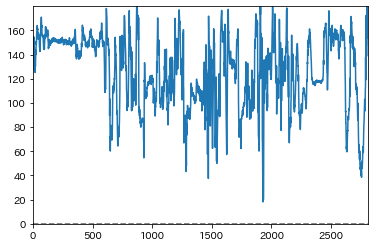

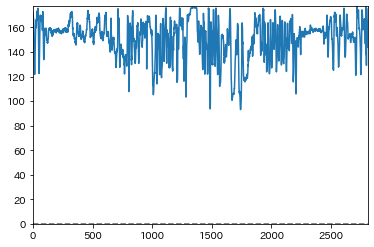

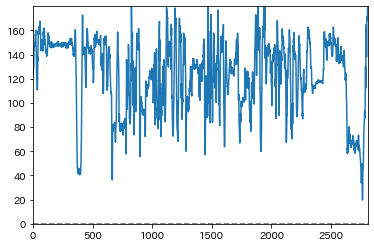

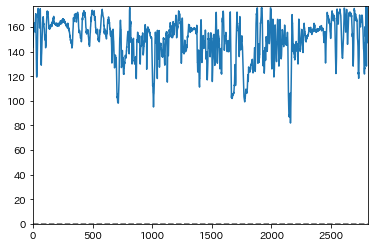

In [22]:
# Kinet
kinect_file_name = "toshi_kinect02.csv"
ELBOW_RIGHT_degree, KNEE_RIGHT_degree, ELBOW_LEFT_degree, KNEE_LEFT_degree = degree(kinect_file_name)

kinect_right_hand = kinect_timing_move(ELBOW_RIGHT_degree, 60, "large")
kinect_right_foot =  kinect_timing_move(KNEE_RIGHT_degree, 60, "large")
kinect_left_hand = kinect_timing_move(ELBOW_LEFT_degree, 60, "large")
kinect_left_foot =  kinect_timing_move(KNEE_LEFT_degree, 60, "large")

In [16]:
print(half_count)

0.33668934240362813


In [8]:
print(melodys_onset.count(1))
print(drums_onset.count(1))
print(vocals_onset.count(1))

49
113
122


### その他使えるデータ

In [273]:
print(melodys_onset)

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [271]:
def Print_onset():
    print('メロディ','ドラム','ボーカル')
    for i in range(len(melodys_onset)):
        print(melodys_onset[i], drums_onset[i], vocals_onset[i])
    return 

def Print_move():
    print("加右手","加右足","加左手","加左足","間右手","間右足","間左手","間左足")
    for i in range(len(accel_right_hand)):
        print(accel_right_hand[i], accel_right_foot[i], accel_left_hand[i], accel_left_foot[i],
             kinect_right_hand[i], kinect_right_foot[i], kinect_left_hand[i], kinect_left_foot[i])
        
def Print_similarly(number):
    length = len(kinect_leftfoot_vocals)
    print("melody", "drum", "vocal")
    if number == "klf":
        for i in range(length):
            print(kinect_leftfoot_melodys[i], kinect_leftfoot_drums[i], kinect_leftfoot_vocals[i])
    if number == "krf":
        for i in range(length):
            print(kinect_rightfoot_melodys[i], kinect_rightfoot_drums[i], kinect_rightfoot_vocals[i])
    if number == "klh":
        for i in range(length):
            print(kinect_lefthand_melodys[i], kinect_lefthand_drums[i], kinect_lefthand_vocals[i])
    if number == "krh":
        for i in range(length):
            print(kinect_righthand_melodys[i], kinect_righthand_drums[i], kinect_righthand_vocals[i])
    if number == "alf":
        for i in range(length):
            print(accel_leftfoot_melodys[i], accel_leftfoot_drums[i], accel_leftfoot_vocals[i])
    if number == "arf":
        for i in range(length):
            print(accel_rightfoot_melodys[i], accel_rightfoot_drums[i], accel_rightfoot_vocals[i])
    if number == "alh":
        for i in range(length):
            print(accel_lefthand_melodys[i], accel_lefthand_drums[i], accel_lefthand_vocals[i])
    if number == "arh":
        for i in range(length):
            print(accel_righthand_melodys[i], accel_righthand_drums[i], accel_righthand_vocals[i])
            
def Print_bodypart():
    body_part_melodys = body_concious_score(accel_leftfoot_melodys,
                               accel_rightfoot_melodys,
                               accel_lefthand_melodys,
                               accel_righthand_melodys,
                               kinect_leftfoot_melodys,
                               kinect_rightfoot_melodys,
                               kinect_lefthand_melodys,
                               kinect_righthand_melodys)

    body_part_drums = body_concious_score(accel_leftfoot_drums,
                                   accel_rightfoot_drums,
                                   accel_lefthand_drums,
                                   accel_righthand_drums,
                                   kinect_leftfoot_drums,
                                   kinect_rightfoot_drums,
                                   kinect_lefthand_drums,
                                   kinect_righthand_drums)

    body_part_vocals = body_concious_score(accel_leftfoot_vocals,
                                   accel_rightfoot_vocals,
                                   accel_lefthand_vocals,
                                   accel_righthand_vocals,
                                   kinect_leftfoot_vocals,
                                   kinect_rightfoot_vocals,
                                   kinect_lefthand_vocals,
                                   kinect_righthand_vocals)  
    
def Print_rulebase():
    rule_base(melody, drum, vocal)
    concious_part = []
    for i in range(len(melody)):
#         print(melody[i], drum[i], vocal[i])

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_11268/2363256020.py, line 73)

In [14]:
time_list = []
for i in range(music_half_count_length):
    time_list.append(i * half_count )
print(time_list)

[0.0, 0.33668934240362813, 0.6733786848072563, 1.0100680272108844, 1.3467573696145125, 1.6834467120181407, 2.020136054421769, 2.356825396825397, 2.693514739229025, 3.030204081632653, 3.3668934240362813, 3.7035827664399097, 4.040272108843538, 4.3769614512471655, 4.713650793650794, 5.050340136054422, 5.38702947845805, 5.723718820861678, 6.060408163265306, 6.397097505668935, 6.733786848072563, 7.070476190476191, 7.407165532879819, 7.743854875283447, 8.080544217687075, 8.417233560090704, 8.753922902494331, 9.09061224489796, 9.427301587301589, 9.763990929705216, 10.100680272108844, 10.437369614512471, 10.7740589569161, 11.110748299319729, 11.447437641723356, 11.784126984126985, 12.120816326530612, 12.45750566893424, 12.79419501133787, 13.130884353741497, 13.467573696145125, 13.804263038548754, 14.140952380952381, 14.47764172335601, 14.814331065759639, 15.151020408163266, 15.487709750566895, 15.824399092970522, 16.16108843537415, 16.497777777777777, 16.834467120181408, 17.171156462585035, 17

### 従来手法

In [9]:
# Estimate

## body_part-music_part
accel_leftfoot_vocals = similary_press_score(accel_left_foot, vocals_onset, 8)
accel_leftfoot_drums = similary_press_score(accel_left_foot, drums_onset, 8)
accel_leftfoot_melodys = similary_press_score(accel_left_foot, melodys_onset, 8)

kinect_leftfoot_vocals = similary_press_score(kinect_left_foot, vocals_onset, 8)
kinect_leftfoot_drums = similary_press_score(kinect_left_foot, drums_onset, 8)
kinect_leftfoot_melodys = similary_press_score(kinect_left_foot, melodys_onset, 8)

accel_lefthand_vocals = similary_press_score(accel_left_hand, vocals_onset, 8)
accel_lefthand_drums = similary_press_score(accel_left_hand, drums_onset, 8)
accel_lefthand_melodys = similary_press_score(accel_left_hand, melodys_onset, 8)

kinect_lefthand_vocals = similary_press_score(kinect_left_hand, vocals_onset, 8)
kinect_lefthand_drums = similary_press_score(kinect_left_hand, drums_onset, 8)
kinect_lefthand_melodys = similary_press_score(kinect_left_hand, melodys_onset, 8)

accel_rightfoot_vocals = similary_press_score(accel_right_foot, vocals_onset, 8)
accel_rightfoot_drums = similary_press_score(accel_right_foot, drums_onset, 8)
accel_rightfoot_melodys = similary_press_score(accel_right_foot, melodys_onset, 8)

kinect_rightfoot_vocals = similary_press_score(kinect_right_foot, vocals_onset, 8)
kinect_rightfoot_drums = similary_press_score(kinect_right_foot, drums_onset, 8)
kinect_rightfoot_melodys = similary_press_score(kinect_right_foot, melodys_onset, 8)

accel_righthand_vocals = similary_press_score(accel_right_hand, vocals_onset, 8)
accel_righthand_drums = similary_press_score(accel_right_hand, drums_onset, 8)
accel_righthand_melodys = similary_press_score(accel_right_hand, melodys_onset, 8)

kinect_righthand_vocals = similary_press_score(kinect_right_hand, vocals_onset, 8)
kinect_righthand_drums = similary_press_score(kinect_right_hand, drums_onset, 8)
kinect_righthand_melodys = similary_press_score(kinect_right_hand, melodys_onset, 8)


estimate_accel_leftfoot = estimated_concious_of_music_part(accel_leftfoot_vocals, accel_leftfoot_melodys, accel_leftfoot_drums)
estimate_accel_lefthand = estimated_concious_of_music_part(accel_lefthand_vocals, accel_lefthand_melodys, accel_lefthand_drums)
estimate_accel_rightfoot = estimated_concious_of_music_part(accel_rightfoot_vocals, accel_rightfoot_melodys, accel_rightfoot_drums)
estimate_accel_righthand = estimated_concious_of_music_part(accel_righthand_vocals, accel_righthand_melodys, accel_righthand_drums)
estimate_kinect_leftfoot = estimated_concious_of_music_part(kinect_leftfoot_vocals, kinect_leftfoot_melodys, kinect_leftfoot_drums)
estimate_kinect_lefthand = estimated_concious_of_music_part(kinect_lefthand_vocals, kinect_lefthand_melodys, kinect_lefthand_drums)
estimate_kinect_rightfoot = estimated_concious_of_music_part(kinect_rightfoot_vocals, kinect_rightfoot_melodys, kinect_rightfoot_drums)
estimate_kinect_righthand = estimated_concious_of_music_part(kinect_righthand_vocals, kinect_righthand_melodys, kinect_righthand_drums)


value_accel_leftfoot = part_to_value(estimate_accel_leftfoot,concious_part)
value_accel_lefthand = part_to_value(estimate_accel_lefthand,concious_part)
value_accel_rightfoot = part_to_value(estimate_accel_rightfoot,concious_part)
value_accel_righthand = part_to_value(estimate_accel_righthand,concious_part)
value_kinect_leftfoot = part_to_value(estimate_kinect_leftfoot,concious_part)
value_kinect_lefthand = part_to_value(estimate_kinect_lefthand,concious_part)
value_kinect_rightfoot = part_to_value(estimate_kinect_rightfoot,concious_part)
value_kinect_righthand = part_to_value(estimate_kinect_righthand,concious_part)


accuracy_accel_leftfoot = estimated_accuracy(estimate_accel_leftfoot,concious_part)
accuracy_accel_lefthand = estimated_accuracy(estimate_accel_lefthand,concious_part)
accuracy_accel_rightfoot = estimated_accuracy(estimate_accel_rightfoot,concious_part)
accuracy_accel_righthand = estimated_accuracy(estimate_accel_righthand,concious_part)
accuracy_kinect_leftfoot = estimated_accuracy(estimate_kinect_leftfoot,concious_part)
accuracy_kinect_lefthand = estimated_accuracy(estimate_kinect_lefthand,concious_part)
accuracy_kinect_rightfoot = estimated_accuracy(estimate_kinect_rightfoot,concious_part)
accuracy_kinect_righthand = estimated_accuracy(estimate_kinect_righthand,concious_part)

# print(accuracy_accel_leftfoot)
# print(accuracy_accel_lefthand)
# print(accuracy_accel_rightfoot)
# print(accuracy_accel_righthand)
# print(accuracy_kinect_leftfoot)
# print(accuracy_kinect_lefthand)
# print(accuracy_kinect_rightfoot)
# print(accuracy_kinect_righthand)


conventional_concious_part = make_concious_part(8, "two")

enl_value_accel_leftfoot = enlarge_sentence(value_accel_leftfoot,100)
enl_value_accel_lefthand = enlarge_sentence(value_accel_lefthand,100)
enl_value_accel_rightfoot = enlarge_sentence(value_accel_rightfoot,100)
enl_value_accel_righthand = enlarge_sentence(value_accel_righthand,100)
enl_value_kinect_leftfoot = enlarge_sentence(value_kinect_leftfoot,100)
enl_value_kinect_lefthand = enlarge_sentence(value_kinect_lefthand,100)
enl_value_kinect_rightfoot = enlarge_sentence(value_kinect_rightfoot,100)
enl_value_kinect_righthand = enlarge_sentence(value_kinect_righthand,100)
enl_value_concious_part = enlarge_sentence(value_concious_part,100)

NameError: name 'concious_part' is not defined

### ルールベース

In [278]:
print(kinect_leftfoot_melodys)

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [12]:
kinect_leftfoot_vocals = similarly_score(kinect_left_foot, vocals_onset)
kinect_leftfoot_drums = similarly_score(kinect_left_foot, drums_onset)
kinect_leftfoot_melodys = similarly_score(kinect_left_foot, melodys_onset)
accel_lefthand_vocals = similarly_score(accel_left_hand, vocals_onset)
accel_lefthand_drums = similarly_score(accel_left_hand, drums_onset)
accel_lefthand_melodys = similarly_score(accel_left_hand, melodys_onset)
kinect_lefthand_vocals = similarly_score(kinect_left_hand, vocals_onset)
kinect_lefthand_drums = similarly_score(kinect_left_hand, drums_onset)
kinect_lefthand_melodys = similarly_score(kinect_left_hand, melodys_onset)
accel_rightfoot_vocals = similarly_score(accel_right_foot, vocals_onset)
accel_rightfoot_drums = similarly_score(accel_right_foot, drums_onset)
accel_rightfoot_melodys = similarly_score(accel_right_foot, melodys_onset)
kinect_rightfoot_vocals = similarly_score(kinect_right_foot, vocals_onset)
kinect_rightfoot_drums = similarly_score(kinect_right_foot, drums_onset)
kinect_rightfoot_melodys = similarly_score(kinect_right_foot, melodys_onset)
accel_righthand_vocals = similarly_score(accel_right_hand, vocals_onset)
accel_righthand_drums = similarly_score(accel_right_hand, drums_onset)
accel_righthand_melodys = similarly_score(accel_right_hand, melodys_onset)
kinect_righthand_vocals = similarly_score(kinect_right_hand, vocals_onset)
kinect_righthand_drums = similarly_score(kinect_right_hand, drums_onset)
kinect_righthand_melodys = similarly_score(kinect_right_hand, melodys_onset)
accel_leftfoot_vocals = similarly_score(accel_left_foot, vocals_onset)
accel_leftfoot_drums = similarly_score(accel_left_foot, drums_onset)
accel_leftfoot_melodys = similarly_score(accel_left_foot, melodys_onset)


rulebase_accel_leftfoot = rule_base(accel_leftfoot_melodys,accel_leftfoot_drums, accel_leftfoot_vocals)
rulebase_accel_rightfoot = rule_base(accel_rightfoot_melodys,accel_rightfoot_drums, accel_rightfoot_vocals)
rulebase_accel_lefthand = rule_base(accel_lefthand_melodys,accel_lefthand_drums, accel_lefthand_vocals)
rulebase_accel_righthand = rule_base(accel_righthand_melodys,accel_righthand_drums, accel_righthand_vocals)
rulebase_kinect_leftfoot = rule_base(kinect_leftfoot_melodys,kinect_leftfoot_drums, kinect_leftfoot_vocals)
rulebase_kinect_rightfoot = rule_base(kinect_rightfoot_melodys,kinect_rightfoot_drums, kinect_rightfoot_vocals)
rulebase_kinect_lefthand = rule_base(kinect_lefthand_melodys,kinect_lefthand_drums, kinect_lefthand_vocals)
rulebase_kinect_righthand = rule_base(kinect_righthand_melodys,kinect_righthand_drums, kinect_righthand_vocals)


body_part = body_concious_part(rulebase_accel_leftfoot,
                               rulebase_accel_rightfoot,
                               rulebase_accel_lefthand,
                               rulebase_accel_righthand,
                               rulebase_kinect_leftfoot,
                               rulebase_kinect_rightfoot,
                               rulebase_kinect_lefthand,
                               rulebase_kinect_righthand)


rule_base_concious_part = make_concious_part(7, "two") 
# del_body_part = delete_break_list(body_part)
sum_body_part = sum_four_counts(del_body_part)
value_rulebase_body_part = part_to_value(sum_body_part,rule_base_concious_part)
# print(sum_body_part)
# print(value_rulebase_body_part)
# del_value_body_part = part_to_value(del_body_part,rule_base_concious_part)
# del_concious_part = delete_break_list(enl_concious_part)
enl_value_rulebase_body_part = enlarge_sentence(value_rulebase_body_part,100)
enl_value_rulebase_concious_part = enlarge_sentence(value_rulebase_body_part,100)
print(enl_value_rulebase_body_part)
# estimated_accuracy(del_body_part,rule_base_concious_part)
# len(estimated_accuracy(del_body_part,rule_base_concious_part))

['なし', 'なし', 'なし', 'なし', 'なし', 'なし', 'なし', 'なし']
['なし', 'なし', 'メロディ', 'なし', 'なし', 'メロディ', 'メロディ', 'メロディ']
['なし', 'なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ']
['なし', 'なし', 'なし', 'なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ']
['なし', 'なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ']
['メロディ', 'なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ']
['なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ']
['メロディ', 'メロディ', 'メロディ', 'なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ']
['なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ']
['なし', 'なし', 'なし', 'なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ']
['メロディ', 'なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'なし', 'メロディ']
['メロディ', 'メロディ', 'なし', 'なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ']
['なし', 'メロディ', 'なし', 'メロディ', 'なし', 'なし', 'メロディ', 'メロディ']
['なし', 'なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'なし', 'メロディ']
['なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'なし', 'メロディ']
['なし', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'メロディ', 'なし']
['なし', 'メロディ', 'なし', 'メロディ', 'なし', 'メロディ', 'メロ

NameError: name 'del_body_part' is not defined

### tf/idf

In [19]:
kinect_leftfoot_vocals = similarly_score(kinect_left_foot, vocals_onset)
kinect_leftfoot_drums = similarly_score(kinect_left_foot, drums_onset)
kinect_leftfoot_melodys = similarly_score(kinect_left_foot, melodys_onset)
accel_lefthand_vocals = similarly_score(accel_left_hand, vocals_onset)
accel_lefthand_drums = similarly_score(accel_left_hand, drums_onset)
accel_lefthand_melodys = similarly_score(accel_left_hand, melodys_onset)
kinect_lefthand_vocals = similarly_score(kinect_left_hand, vocals_onset)
kinect_lefthand_drums = similarly_score(kinect_left_hand, drums_onset)
kinect_lefthand_melodys = similarly_score(kinect_left_hand, melodys_onset)
accel_rightfoot_vocals = similarly_score(accel_right_foot, vocals_onset)
accel_rightfoot_drums = similarly_score(accel_right_foot, drums_onset)
accel_rightfoot_melodys = similarly_score(accel_right_foot, melodys_onset)
kinect_rightfoot_vocals = similarly_score(kinect_right_foot, vocals_onset)
kinect_rightfoot_drums = similarly_score(kinect_right_foot, drums_onset)
kinect_rightfoot_melodys = similarly_score(kinect_right_foot, melodys_onset)
accel_righthand_vocals = similarly_score(accel_right_hand, vocals_onset)
accel_righthand_drums = similarly_score(accel_right_hand, drums_onset)
accel_righthand_melodys = similarly_score(accel_right_hand, melodys_onset)
kinect_righthand_vocals = similarly_score(kinect_right_hand, vocals_onset)
kinect_righthand_drums = similarly_score(kinect_right_hand, drums_onset)
kinect_righthand_melodys = similarly_score(kinect_right_hand, melodys_onset)
accel_leftfoot_vocals = similarly_score(accel_left_foot, vocals_onset)
accel_leftfoot_drums = similarly_score(accel_left_foot, drums_onset)
accel_leftfoot_melodys = similarly_score(accel_left_foot, melodys_onset)

body_part_melodys = body_concious_score(accel_leftfoot_melodys,
                               accel_rightfoot_melodys,
                               accel_lefthand_melodys,
                               accel_righthand_melodys,
                               kinect_leftfoot_melodys,
                               kinect_rightfoot_melodys,
                               kinect_lefthand_melodys,
                               kinect_righthand_melodys)

body_part_drums = body_concious_score(accel_leftfoot_drums,
                               accel_rightfoot_drums,
                               accel_lefthand_drums,
                               accel_righthand_drums,
                               kinect_leftfoot_drums,
                               kinect_rightfoot_drums,
                               kinect_lefthand_drums,
                               kinect_righthand_drums)

body_part_vocals = body_concious_score(accel_leftfoot_vocals,
                               accel_rightfoot_vocals,
                               accel_lefthand_vocals,
                               accel_righthand_vocals,
                               kinect_leftfoot_vocals,
                               kinect_rightfoot_vocals,
                               kinect_lefthand_vocals,
                               kinect_righthand_vocals)        


body_part_melodys = ideal_vocals
body_part_drums = ideal_melodys
body_part_vocals = ideal_drums


# del_melodys_onset = delete_break_list(melodys_onset)
# del_drums_onset = delete_break_list(drums_onset)
# del_vocals_onset = delete_break_list(vocals_onset)

# del_body_part_melodys = delete_break_list(body_part_melodys)
# del_body_part_drums = delete_break_list(body_part_drums)
# del_body_part_vocals = delete_break_list(body_part_vocals)

# print(sum(del_body_part_drums))

# body_melody_tf_idf = tf_idf(del_melodys_onset,del_body_part_melodys)
# body_drum_tf_idf = tf_idf(del_drums_onset,del_body_part_drums)
# body_vocal_tf_idf = tf_idf(del_vocals_onset,del_body_part_vocals)

# four_counts_body_melody_tf_idf = tf_idf_four_counts(body_melody_tf_idf, 4)
# four_counts_body_drum_tf_idf = tf_idf_four_counts(body_drum_tf_idf, 4)
# four_counts_body_vocal_tf_idf = tf_idf_four_counts(body_vocal_tf_idf, 4)

# body_tf_idf = estimated_concious_of_music_part(four_counts_body_vocal_tf_idf, four_counts_body_melody_tf_idf, four_counts_body_drum_tf_idf)

body_tf_idf = tf_idf(body_part_melodys, body_part_drums, body_part_vocals)
# body_tf_idf = tf_idf(del_body_part_melodys, del_body_part_drums, del_body_part_vocals)
print(body_tf_idf)

tf_idf_concious_part = toshi_accuracy_data
# tf_idf_concious_part = make_concious_part(7, "two")
value_tf_idf_concious_part = part_to_value(tf_idf_concious_part,tf_idf_concious_part)
enl_value_tf_idf_concious_part = enlarge_sentence(value_tf_idf_concious_part,100)
value_tfidf_body_part = part_to_value(body_tf_idf,tf_idf_concious_part)
enl_value_tfidf_body_part = enlarge_sentence(value_tfidf_body_part,100)
# estimated_accuracy(body_tf_idf,tf_idf_concious_part)
# print(value_tfidf_body_part)

[['ボーカル'], ['メロディ'], ['ボーカル'], ['ボーカル'], ['メロディ'], ['ドラム'], ['ボーカル'], ['ボーカル'], ['メロディ'], ['ドラム'], ['ボーカル'], ['メロディ'], ['メロディ'], ['ドラム'], ['メロディ'], ['ボーカル'], ['ドラム'], ['ボーカル'], ['ボーカル'], ['ボーカル'], ['メロディ'], ['ドラム']]


TypeError: 'int' object is not iterable

In [20]:
import openpyxl
import csv
import sys
sys.getdefaultencoding()

'utf-8'

# tfidfの改良

In [17]:
toshi_ideal_df = pd.read_csv('uww2021_ideal_data.csv',skiprows=[0], header=None, usecols=[2, 3, 4], encoding="utf-8")
# toshi_ideal_df = pd.read_csv('toshi_ideal_data.csv',skiprows=[0,1], header=None, usecols=[9, 10, 11], encoding="cp932")
toshi_ideal_df.columns=["ボーカル", "メロディ", "ドラム",]
# toshi_df.append([0,0,0])
ideal_vocals = toshi_ideal_df['ボーカル']
ideal_melodys = toshi_ideal_df['メロディ']
ideal_drums = toshi_ideal_df['ドラム']
print(ideal_vocals, ideal_melodys)

# for i in range(164, 180):
#     ideal_vocals[i] = 0
#     ideal_melodys[i] = 0
#     ideal_drums[i] = 0

# print(toshi_df)

0      0
1      0
2      0
3      0
4      0
      ..
163    1
164    1
165    0
166    1
167    1
Name: ボーカル, Length: 168, dtype: int64 0      1
1      1
2      1
3      1
4      0
      ..
163    0
164    0
165    0
166    0
167    0
Name: メロディ, Length: 168, dtype: int64


In [121]:
def create_idf(line, length):
    result = []
    idf_length_list = [[0, 56], [56, 112], [112, 168]]
#     idf_length_list = [[0, 32], [32, 56], [56, 88], [88, 112], [112, 144], [144, 168]]
#     idf_length_list = [[0, 36], [36, 68], [68, 100], [100, 132], [132, 164] ]
    for idf_length in idf_length_list:
        start, end = idf_length[0], idf_length[1]
        for _ in range(length):
            result.append(sum(line[start: end]))
#     result.insert(0, sum(line[0: 36]))
#     result.append(0)
#     result.append(0)
#     del result[23]
#     del result[15]
#     del result[7]
#     print(result[23], result[15], result[7])
    return result

print(create_idf(ideal_vocals, 7))
print(len(create_idf(ideal_melodys, 7)))
# print(ideal_vocals[164:180])

[13, 13, 13, 13, 13, 13, 13, 39, 39, 39, 39, 39, 39, 39, 42, 42, 42, 42, 42, 42, 42]
21


In [44]:
a=[[1,2,3], [4, 5, 6]]
print(a[:][1])

[4, 5, 6]


In [47]:
q=[(1,2,3), (4, 5, 5)]
for a, b, c in q:
    print(a, b, c)

1 2 3
4 5 5


In [48]:
q=[1,2,3,4,5]
s=[sum(q) for _ in range(3)]
print(s)

[15, 15, 15]


In [78]:
# def create_idf(line, length):
#     result = []
#     idf_length_list = [[0, 36], [36, 68], [68, 100], [100, 132], [132, 164]]
#     for idf_length in idf_length_list:
#         start, end = idf_length[0], idf_length[1]
#         for _ in range(length):
#             result.append(sum(line[start: end]))
#     result.insert(0, sum(line[0: 36]))
#     result.append(0)
#     result.append(0)
#     return result

def create_idf(line, length):
    result = []
    idf_length_list = [[0, 32], [32, 56], [56, 88], [88, 112], [112, 144], [144, 168]]
#     idf_length_list = [[0, 36], [36, 68], [68, 100], [100, 132], [132, 164] ]
    for idf_length in idf_length_list:
        start, end = idf_length[0], idf_length[1]
        for _ in range(length):
            result.append(sum(line[start: end]))
#     result.insert(0, sum(line[0: 36]))
#     result.append(0)
#     result.append(0)
    del result[23]
    del result[15]
    del result[7]
#     print(result[23], result[15], result[7])
    return result

# def create_idf(line, length):
#     result = []
#     idf_length_list = [[0, 56], [56, 112], [112, 168]]
# #     idf_length_list = [[0, 32], [32, 56], [56, 88], [88, 112], [112, 144], [144, 168]]
# #     idf_length_list = [[0, 36], [36, 68], [68, 100], [100, 132], [132, 164] ]
#     for idf_length in idf_length_list:
#         start, end = idf_length[0], idf_length[1]
#         for _ in range(length):
#             result.append(sum(line[start: end]))
# #     result.insert(0, sum(line[0: 36]))
# #     result.append(0)
# #     result.append(0)
# #     del result[23]
# #     del result[15]
# #     del result[7]
# #     print(result[23], result[15], result[7])
#     return result

# print(create_idf(ideal_vocals, 7))
# print(len(create_idf(ideal_melodys, 7)))
# print(ideal_vocals[164:180])
    
    
def print_tfidf(v_tfidf_list, m_tfidf_list, d_tfidf_list):
    figure_time_list = []
    for i in range(len(v_tfidf_list)):
        figure_time_list.append(i * 16 * quarter_count)
#         figure_time_list.append(i * 16 * quarter_count / 100)
    x1 = figure_time_list

    # UWW用
    # y1 = del_body_part_vocals
    # y2 = del_body_part_drums
    # y3 = del_body_part_melodys

    # y1 = body_part_vocals
    # y2 = body_part_drums
    # y3 = body_part_melodys

    # y1 = data_to_boolint_vocals
    # y2 = data_to_boolint_drums
    # y3 = data_to_boolint_melodys

    # y1 = compare_ideal_and_real_vocals
    # y2 = compare_ideal_and_real_drums
    # y3 = compare_ideal_and_real_melodys

    y1 = v_tfidf_list
    y2 = d_tfidf_list
    y3 = m_tfidf_list

    # plt.subplot(3,1,1)
    # plt.plot(x,y1)

    # plt.subplot(3,1,2)
    # plt.plot(x,y2)

    # plt.subplot(3,1,3)
    # plt.plot(x,y3)

    fig = plt.figure(figsize=(12, 8)) #...1

    #図の形式定義
    plt.rcParams['font.family'] ='Yu Gothic'#使用するフォント
    plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
    plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
    plt.rcParams['font.size'] = 15 #フォントの大きさ
    plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ

#     label_l = ['', 'real', 'ideal', '(0,0)', '(1,1)']
    # label_l = ['', '合っていない', '(0,0)', '(1,1)']
    # label_l = ['', 'メロディ', 'ドラム', 'ボーカル']

    ax = fig.add_subplot(3, 1, 1)#(行，列，領域番号)
    ax.plot(x1, y1,c="blue",linewidth=0.4)
    # ax.plot(x1, y3,c="red",label='意識したパート',linewidth=0.4)
    ax.set_xlabel('時間[秒]',fontsize=18)
    ax.set_ylabel('tf/idf',fontsize=18)
    # ax.set_ylabel('条件Sの発生回数[回]',fontsize=18)
    # ax.set_yticks([-10,-5, 0,5, 10])
    #     ax.set_ylabel('acc')
    #     ax.set_xlim((0,14000))
    ax.set_ylim((0, 1.2))
#     ax.set_ylim((-2.2, 1.2))
    ax.set_title("ボーカル",fontsize=22)
    ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(1, -1))
#     ax.set_yticklabels(label_l, ha='right',fontsize=14)
    # ax.legend(fontsize=15)
    #     ax.show()

    ax = fig.add_subplot(3, 1, 2)
    ax.plot(x1, y2,c="green",linewidth=0.4)
    # ax.plot(x1, y3,c="red",label='意識したパート',linewidth=0.4)
    ax.set_xlabel('時間[秒]',fontsize=18)
    ax.set_ylabel('tf/idf',fontsize=18)
    # ax.set_ylabel('条件Sの発生回数[回]',fontsize=18)
    #     ax.set_ylabel('ang')
    #     ax.set_xlim((0,14000))
    ax.set_title("ドラム",fontsize=22)
    ax.set_ylim((0, 1.2))
#     ax.set_ylim((-2.2, 1.2))
    ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(1, -1))
#     ax.set_yticklabels(label_l, ha='right',fontsize=14)
    # ax.legend(fontsize=15)

    ax = fig.add_subplot(3, 1, 3)
    ax.plot(x1, y3,c="red",linewidth=0.4)
    # ax.plot(x1, y3,c="red",label='意識したパート',linewidth=0.4)
    ax.set_xlabel('時間[秒]',fontsize=18)
    #     ax.set_ylabel('ang')
    #     ax.set_xlim((0,14000))
    ax.set_title("メロディ",fontsize=22)
    ax.set_ylabel('tf/idf',fontsize=18)
    # ax.set_ylabel('条件Sの発生回数[回]',fontsize=18)
    ax.set_ylim((0, 1.2))
#     ax.set_ylim((-2.2, 1.2))
    ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(1, -1))
#     ax.set_yticklabels(label_l, ha='right',fontsize=14)
    # ax.legend(fontsize=15)

    # figname = 'uww2021_dataA_2.pdf'
    plt.tight_layout()    

    # plt.show()


    
    
def one_dimension_tfidf(vocal, melody, drum, start, length, interval, must_plot, j):

    v_sum = sum(vocal)
    m_sum = sum(melody)
    d_sum = sum(drum)
    
    idf_length = 6
#     idf_length = 12
#     idf_length = length//interval
    
    v_idf = [sum(vocal) for _ in range(idf_length)]
    m_idf = [sum(melody) for _ in range(idf_length)]
    d_idf = [sum(drum) for _ in range(idf_length)]
#     print(v_idf)
    
#     v_idf = create_idf(vocal, 7)
#     m_idf = create_idf(melody, 7)
#     d_idf = create_idf(drum, 7)
    
#     v_idf = create_idf(vocal, 4)
#     m_idf = create_idf(melody, 4)
#     d_idf = create_idf(drum, 4)
    
    tf_idf_result = [] 
    end = start + length
#     print(len(v_idf))
#     print(v_idf)
    
    v_tfidf_list = []
    m_tfidf_list = []
    d_tfidf_list = []
    count = 0
#     print(start, end, interval)
    for i in range(start, end, interval):
        v_measure = sum(vocal[i:i+interval])
#         print(j)
#         print(i, i+interval)
        count += 1
#         print('interval:', i, i+interval, 'j:', j, 'count:', count)
        if v_measure: v_tfidf = v_measure / v_idf[j]
        else: v_tfidf = 0
        v_tfidf_list.append(v_tfidf)
#         print(vocal[i:i+interval])
#         print('vocal')
        print(v_measure, v_idf[j])
#         v_tfidf = v_measure / v_sum
        
        m_measure = sum(melody[i:i+interval])
#         print(melody[i:i+interval])
#         print('melody')
#         print(m_measure, m_idf[j])
        if m_measure: m_tfidf = m_measure / m_idf[j]
        else: m_tfidf = 0
#         m_tfidf = m_measure / m_idf[j]
        m_tfidf_list.append(m_tfidf)
#         m_tfidf = m_measure / m_sum

        
        d_measure = sum(drum[i:i+interval])
        if d_measure: d_tfidf = d_measure / d_idf[j]
        else: d_tfidf = 0
#         print('drum')
#         print(d_measure, d_idf[j])
#         d_tfidf = d_measure / d_idf[j]
        d_tfidf_list.append(d_tfidf)
#         d_tfidf = d_measure / d_sum
        compare_tfidf_list = [v_tfidf, m_tfidf, d_tfidf]
        compare_measure_list = [v_measure, m_measure, d_measure]
        compare_sum_list = [v_sum, m_sum, d_sum]
        part_list = ['ボーカル', 'メロディ', 'ドラム']

        max_num = max(v_tfidf, m_tfidf, d_tfidf)
        
        tf_idf_list = []
        max_list = [i for i, x in enumerate(compare_tfidf_list) if x == max_num]
        if max_num == 0:
            tf_idf_list.append('None')
            

        elif len(max_list) >= 2:
            new_max = ['', -1]
            for num in max_list:
                tmp_tfidf = compare_measure_list[num] / compare_sum_list[num]
                if new_max[1] < tmp_tfidf:
                    new_max[0], new_max[1] = part_list[num], tmp_tfidf
            tf_idf_list.append(new_max[0])
                
                
        else:   
            if v_tfidf == max_num:
                tf_idf_list.append('ボーカル')
            if m_tfidf == max_num:
                tf_idf_list.append('メロディ')
            if d_tfidf == max_num:
                tf_idf_list.append('ドラム')
                
            

        tf_idf_result.append(tf_idf_list)
#         print(tf_idf_result)
        j += 1

#     if must_plot:
#         print_tfidf(v_tfidf_list, m_tfidf_list, d_tfidf_list)
#     print([v_tfidf_list, m_tfidf_list, d_tfidf_list])
    return tf_idf_result, v_tfidf_list, m_tfidf_list, d_tfidf_list, j
    
def break_list(input_list):
    ans = []
    v_tfidf_list = []
    m_tfidf_list = []
    d_tfidf_list = []
    length = len(input_list)
    for i in range(length):
        ans += input_list[i][0]
        v_tfidf_list += input_list[i][1]
        m_tfidf_list += input_list[i][2]
        d_tfidf_list += input_list[i][3]
    return ans, v_tfidf_list, m_tfidf_list, d_tfidf_list
    
def one_dimension_part_to_value(vocal, melody, drum, must_plot):
    ans = []
    v_tfidf_list = []
    m_tfidf_list = []
    d_tfidf_list = []
    j = 0
#     print(music_half_count_length)
#     ans += one_dimension_tfidf(vocal, melody, drum, 0, 32, 8)
#     ans += one_dimension_tfidf(vocal, melody, drum, 32, 4, 4)

#     ans += one_dimension_tfidf(vocal, melody, drum, 0, music_half_count_length-24, 8, must_plot, j)
#     ans = ans[:-3]
    
#     ans += one_dimension_tfidf(vocal, melody, drum, 0, 32, 4)
#     ans += one_dimension_tfidf(vocal, melody, drum, 32, 4, 4)
#     ans += one_dimension_tfidf(vocal, melody, drum, 36, music_half_count_length-36, 4)

#     ans += one_dimension_tfidf(vocal, melody, drum, 0, 32, 16)
#     ans += one_dimension_tfidf(vocal, melody, drum, 32, 4, 4)
#     ans += one_dimension_tfidf(vocal, melody, drum, 36, music_half_count_length-36, 16)
    
#     ans_tmp, v_tfidf_list_tmp, m_tfidf_list_tmp, d_tfidf_list_tmp, j = one_dimension_tfidf(vocal, melody, drum, 0, 32, 8, must_plot, j)
#     ans += ans_tmp
#     v_tfidf_list += v_tfidf_list_tmp
#     m_tfidf_list += m_tfidf_list_tmp
#     d_tfidf_list += d_tfidf_list_tmp
#     ans_tmp, v_tfidf_list_tmp, m_tfidf_list_tmp, d_tfidf_list_tmp, j = one_dimension_tfidf(vocal, melody, drum, 32, 4, 4, must_plot, j)
#     ans += ans_tmp
#     v_tfidf_list += v_tfidf_list_tmp
#     m_tfidf_list += m_tfidf_list_tmp
#     d_tfidf_list += d_tfidf_list_tmp
#     ans_tmp, v_tfidf_list_tmp, m_tfidf_list_tmp, d_tfidf_list_tmp, j = one_dimension_tfidf(vocal, melody, drum, 36, music_half_count_length-36, 8, must_plot, j)
#     ans += ans_tmp
#     v_tfidf_list += v_tfidf_list_tmp
#     m_tfidf_list += m_tfidf_list_tmp
#     d_tfidf_list += d_tfidf_list_tmp
#     l = 0
#     interval_list = [16, 12]
#     interval_list = [16, 16, 16, 8]
#     tf_range_list = [(0, 48, 16), (48, 8, 8), (56, 48, 16), (104, 8, 8), (112, 48, 16), (160, 8, 8)]
    tf_range_list = [(0, 32, 32), (32, 24, 24), (56, 32, 32), (88, 24, 24), (112, 32, 32), (144, 24, 24)]

    for start, end, interval in tf_range_list:
        ans_tmp, v_tfidf_list_tmp, m_tfidf_list_tmp, d_tfidf_list_tmp, j = one_dimension_tfidf(vocal, melody, drum, start, end, interval, must_plot, j)
#         ans_tmp, v_tfidf_list_tmp, m_tfidf_list_tmp, d_tfidf_list_tmp, j = one_dimension_tfidf(vocal, melody, drum, start, music_half_count_length-24, interval, must_plot, j)
        ans += ans_tmp
        v_tfidf_list += v_tfidf_list_tmp
        m_tfidf_list += m_tfidf_list_tmp
        d_tfidf_list += d_tfidf_list_tmp
    
    
#     ans_tmp, v_tfidf_list_tmp, m_tfidf_list_tmp, d_tfidf_list_tmp, j = one_dimension_tfidf(vocal, melody, drum, 0, music_half_count_length-24, 8, must_plot, j)
#     ans += ans_tmp
#     v_tfidf_list += v_tfidf_list_tmp
#     m_tfidf_list += m_tfidf_list_tmp
#     d_tfidf_list += d_tfidf_list_tmp
    
#     ans_tmp, v_tfidf_list_tmp, m_tfidf_list_tmp, d_tfidf_list_tmp, j = one_dimension_tfidf(vocal, melody, drum, 0, music_half_count_length-24, 8, must_plot, j)
#     ans += ans_tmp
#     v_tfidf_list += v_tfidf_list_tmp
#     m_tfidf_list += m_tfidf_list_tmp
#     d_tfidf_list += d_tfidf_list_tmp
#     print(ans)
#     print(v_tfidf_list)
#     print(m_tfidf_list)
#     print(d_tfidf_list)
#     ans, v_tfidf_list, m_tfidf_list, d_tfidf_list = break_list(all_tfidf_list)
    
    if must_plot:
        print_tfidf(v_tfidf_list, m_tfidf_list, d_tfidf_list)
#     print(v_tfidf_list)
    tfidf_df = pd.DataFrame({
        'ボーカル': v_tfidf_list,
        'メロディ': m_tfidf_list,
        'ドラム': d_tfidf_list,
        '意識したパート': ans
    })
    tfidf_df.to_clipboard()
#     print(tfidf_df)
    return ans

7 94
6 94
19 94
20 94
24 94
18 94
[2, 2, 1, 3, 3, 3]


C:\Users\tsuka\AppData\Local\Temp/ipykernel_17016/2885827538.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(label_l, ha='right',fontsize=22)


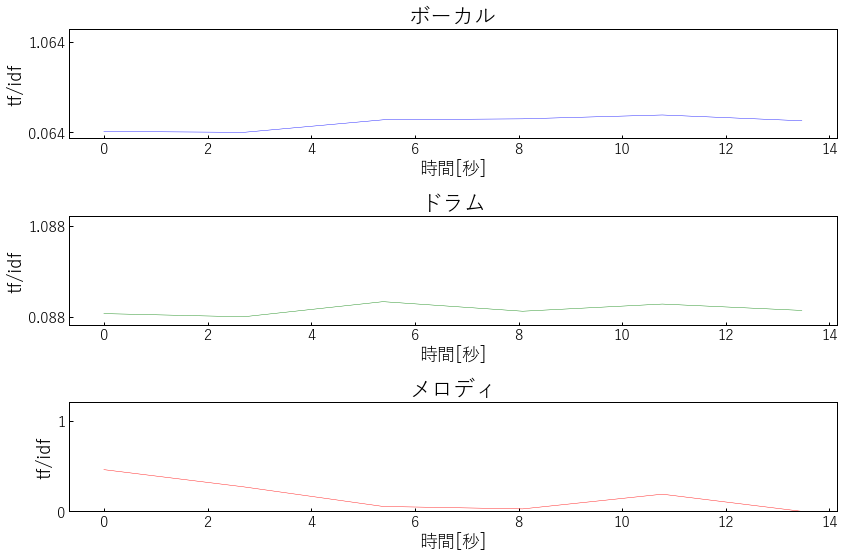

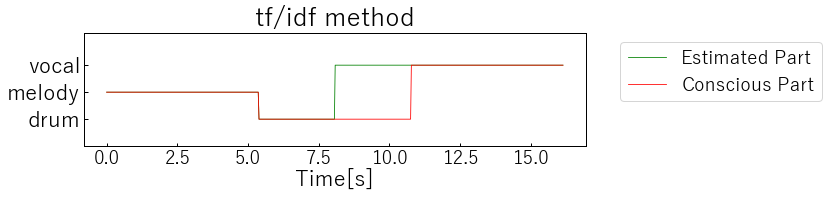

In [79]:
must_plot = True
toshi_rule_base =  toshi_rulebase_func(ideal_vocals, ideal_melodys, ideal_drums)
toshi_tf_idf = one_dimension_part_to_value(ideal_vocals, ideal_melodys, ideal_drums, must_plot)
int_toshi_tf_idf = to_int(toshi_tf_idf)
print(int_toshi_tf_idf)
# print(len(toshi_tf_idf))
int_toshi_rule_base = to_int(toshi_rule_base)
enl_int_toshi_rule_base = enlarge_sentence(int_toshi_rule_base, 100)
enl_int_toshi_tf_idf = enlarge_sentence(int_toshi_tf_idf, 100)
enl_int_toshi_accuracy_data = enlarge_sentence(uww2021_accuracy_data, 100)
# enl_int_toshi_rule_base = enlarge_sentence(int_toshi_rule_base, 100)
# enl_int_toshi_tf_idf = enlarge_sentence(int_toshi_tf_idf, 100)
# enl_int_toshi_accuracy_data = enlarge_sentence(int_toshi_accuracy_data, 100)
# enl_int_toshi_accuracy_data = enlarge_sentence(int_toshi_double_accuracy_data, 100)
# enl_int_toshi_accuracy_data = enlarge_sentence(int_toshi_half_accuracy_data, 100)

to_figure(enl_int_toshi_accuracy_data,
    enl_int_toshi_tf_idf,
    enl_int_toshi_accuracy_data)

In [60]:
# rule_score = 0
# for i, j in zip(uww2021_accuracy_data, int_toshi_rule_base):
# # for i, j in zip(int_toshi_accuracy_data, int_toshi_rule_base):
#     if i == j:
#         rule_score += 1

# rule_score = (rule_score / 23) * 100

tf_score = 0
for i, j in zip(uww2021_accuracy_data, int_toshi_tf_idf):
# for i, j in zip(int_toshi_accuracy_data, int_toshi_tf_idf):
    if i == j:
        tf_score += 1
        
tf_score = (tf_score / len(int_toshi_tf_idf)) * 100

print(tf_score)

83.33333333333334


In [73]:
# uww2021_accuracy_data = [2,2,2,2,1,1,1,1,3,3,3,3]
uww2021_accuracy_data = [2,2,1,1,3,3]
# uww2021_accuracy_data = [2,2,2,2,2,2,2,1,1,1,1,1,1,1,3,3,3,3,3,3,3]
int_toshi_accuracy_data = [2, 2, 2, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
int_toshi_half_accuracy_data = [2, 2, 2, 1, 1, 3, 3, 1, 1, 1, 1, 0]
int_toshi_double_accuracy_data = []
for num in int_toshi_accuracy_data:
    for _ in range(2):
        int_toshi_double_accuracy_data.append(num)
del int_toshi_double_accuracy_data[9]
print(len(int_toshi_accuracy_data))
print(int_toshi_double_accuracy_data)

23
[2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


RuleBaseの改良

In [ ]:
def one_dimension_rulebase(vocal, melody, drum):
    rule_base_ans = []
    for v, m, d in zip(vocal, melody, drum):
        if m:
            rule_base_ans.append('メロディ')
        elif v:
            rule_base_ans.append('ボーカル')
            
        elif d:
            rule_base_ans.append('ドラム')
            

            
        else:
            rule_base_ans.append('None')
            
    return rule_base_ans

def one_dimension_rulebase_sum(vocal, melody, drum, start, length, interval):
    rule_base_ans = one_dimension_rulebase(vocal, melody, drum)
    rule_base_result = [] 
    end = start + length
    for i in range(start, end, interval):
        v_measure = rule_base_ans[i:i+interval].count('ボーカル')
        
        m_measure = rule_base_ans[i:i+interval].count('メロディ')
        
        d_measure = rule_base_ans[i:i+interval].count('ドラム')
        
        max_num = max(v_measure, m_measure, d_measure)
        
        rule_base_list = []
        
        if max_num == 0:
            rule_base_list.append('None')
        
        else:   
            if m_measure == max_num:
                rule_base_list.append('メロディ')
            elif v_measure == max_num:
                rule_base_list.append('ボーカル')
            elif d_measure == max_num:
                rule_base_list.append('ドラム')

                
#         else:   
#             if v_measure == max_num:
#                 rule_base_list.append('ボーカル')
#             elif d_measure == max_num:
#                 rule_base_list.append('ドラム')
#             elif m_measure == max_num:
#                 rule_base_list.append('メロディ')


        rule_base_result.append(rule_base_list)
#         print(tf_idf_result)
    
    return rule_base_result
    
    
def toshi_rulebase_func(vocal, melody, drum):    
    ans=[]
#     ans += one_dimension_rulebase_sum(vocal, melody, drum, 0, 32, 8)
#     ans += one_dimension_rulebase_sum(vocal, melody, drum, 32, 4, 4)
#     ans += one_dimension_rulebase_sum(vocal, melody, drum, 0, music_half_count_length, 8)
#     ans = ans[:-3]
    
    
    ans += one_dimension_rulebase_sum(vocal, melody, drum, 0, 32, 8)
    ans += one_dimension_rulebase_sum(vocal, melody, drum, 32, 4, 4)
    ans += one_dimension_rulebase_sum(vocal, melody, drum, 36, music_half_count_length-36, 8)
    return ans

In [11]:
import itertools

In [18]:
for v in itertools.permutations(["ボーカル", 'メロディ', 'ドラム'], 3):
    print(v)

('ボーカル', 'メロディ', 'ドラム')
('ボーカル', 'ドラム', 'メロディ')
('メロディ', 'ボーカル', 'ドラム')
('メロディ', 'ドラム', 'ボーカル')
('ドラム', 'ボーカル', 'メロディ')
('ドラム', 'メロディ', 'ボーカル')


In [19]:
print('aa' in ['aa', 'bb'])

True


# トシの申告による正解データ

In [13]:
def to_int(parts: list):
    int_list = []
    for part in parts:
        if part == ['ボーカル']:
            int_list.append(3)
        elif part == ['メロディ']:
            int_list.append(2)
        elif part == ['ドラム']:
            int_list.append(1)
        elif part == ['None']:
            int_list.append(0)
            
    return int_list

In [49]:
int_toshi_tf_idf
int_toshi_rule_base
uww2021_accuracy_data

[2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3]

In [21]:
int_toshi_tf_idf = to_int(toshi_tf_idf)
int_toshi_rule_base = to_int(toshi_rule_base)

print(int_toshi_rule_base)
print(int_toshi_tf_idf)
print(toshi_tf_idf)

[2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
[1, 3, 1, 1, 3, 2, 3, 1, 3, 3, 1, 1, 3, 2, 3, 1, 3, 1, 1, 2, 3, 0, 0]
[['ドラム'], ['ボーカル'], ['ドラム'], ['ドラム'], ['ボーカル'], ['メロディ'], ['ボーカル'], ['ドラム'], ['ボーカル'], ['ボーカル'], ['ドラム'], ['ドラム'], ['ボーカル'], ['メロディ'], ['ボーカル'], ['ドラム'], ['ボーカル'], ['ドラム'], ['ドラム'], ['メロディ'], ['ボーカル'], ['None'], ['None']]


In [21]:
toshi_accuracy_df = pd.read_csv('toshi_dance_exam.csv',skiprows=[0,1,2], header=None, usecols=[4], encoding="cp932")
toshi_accuracy_df.columns=["正解値"]
toshi_accuracy_data_csv = toshi_accuracy_df['正解値']


toshi_accuracy_data = []

for num in toshi_accuracy_data_csv:
    for _ in range(2):
        toshi_accuracy_data.append(num)
    
print(toshi_accuracy_data)


fix_toshi_accuracy_data = []
for num in toshi_accuracy_data:
    if num == 0:
        fix_toshi_accuracy_data.append(0)
    else:
        fix_toshi_accuracy_data.append(num-1)
        
print(fix_toshi_accuracy_data)

# print(len(toshi_accuracy_data))

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [20]:
int_toshi_accuracy_data = [2, 2, 2, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
uww2021_accuracy_data = [2,2,2,2,2,2,2,1,1,1,1,1,1,1,3,3,3,3,3,3,3]
int_toshi_double_accuracy_data = []
for num in int_toshi_accuracy_data:
    for _ in range(2):
        int_toshi_double_accuracy_data.append(num)
del int_toshi_double_accuracy_data[9]
print(len(int_toshi_accuracy_data))
print(int_toshi_double_accuracy_data)

23
[2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


In [19]:
uww2021_accuracy_data = [2,2,2,2,2,2,2,1,1,1,1,1,1,1,3,3,3,3,3,3,3]
print(len(uww2021_accuracy_data))

21


# 理想データから作成したトシのtfidf出力

In [14]:
toshi_rule_base =  toshi_rulebase_func(ideal_vocals, ideal_melodys, ideal_drums)
print(toshi_rule_base)
print(len(toshi_rule_base))

[['メロディ'], ['メロディ'], ['メロディ'], ['メロディ'], ['ボーカル'], ['メロディ'], ['メロディ'], ['メロディ'], ['ボーカル'], ['メロディ'], ['メロディ'], ['メロディ'], ['メロディ'], ['メロディ'], ['メロディ'], ['メロディ'], ['メロディ'], ['メロディ'], ['メロディ'], ['メロディ']]
20


In [15]:
toshi_tf_idf = one_dimension_part_to_value(ideal_vocals, ideal_melodys, ideal_drums)
print(toshi_tf_idf)
print(len(toshi_tf_idf))

[['ドラム'], ['ボーカル'], ['ドラム'], ['ドラム'], ['ボーカル'], ['メロディ'], ['ドラム'], ['ドラム'], ['ボーカル'], ['メロディ'], ['ドラム'], ['ボーカル'], ['ボーカル'], ['メロディ'], ['ボーカル'], ['ドラム'], ['メロディ'], ['ドラム'], ['ドラム'], ['ドラム']]
20


# 理想データから作成したトシのルールベース出力 

# 目視による正解データ 

# 入力データと理想のデータの比較

In [22]:
def compare_ideal_and_real(ideal_data, real_data):
    result = []
    for ideal_num, real_num in zip(ideal_data, real_data):
        if ideal_num == real_num == 1:
            result.append(1)
        elif ideal_num == real_num == 0:
            result.append(0)
        elif ideal_num == 1 and real_num == 0:
            result.append(-1)
        else:
            result.append(-2)
    return result

compare_ideal_and_real_vocals = compare_ideal_and_real(ideal_vocals, data_to_boolint_vocals)
compare_ideal_and_real_melodys = compare_ideal_and_real(ideal_melodys, data_to_boolint_melodys)
compare_ideal_and_real_drums = compare_ideal_and_real(ideal_drums, data_to_boolint_drums)

print(compare_ideal_and_real_vocals.count(-1))
print(compare_ideal_and_real_melodys.count(-1))
print(compare_ideal_and_real_drums.count(-1))


NameError: name 'data_to_boolint_vocals' is not defined

In [23]:
def data_to_boolint(body_part_music):
    result =[]
    for num in body_part_music:
        if num > 0:
            result.append(1)
        else:
            result.append(0)
        
    return result

data_to_boolint_vocals = data_to_boolint(body_part_vocals)
data_to_boolint_melodys = data_to_boolint(body_part_melodys)
data_to_boolint_drums = data_to_boolint(body_part_drums)

print(data_to_boolint_drums)

NameError: name 'body_part_vocals' is not defined

C:\Users\tsuka\AppData\Local\Temp/ipykernel_12864/3382686064.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(label_l, ha='right',fontsize=14)
C:\Users\tsuka\AppData\Local\Temp/ipykernel_12864/3382686064.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(label_l, ha='right',fontsize=14)
C:\Users\tsuka\AppData\Local\Temp/ipykernel_12864/3382686064.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(label_l, ha='right',fontsize=14)


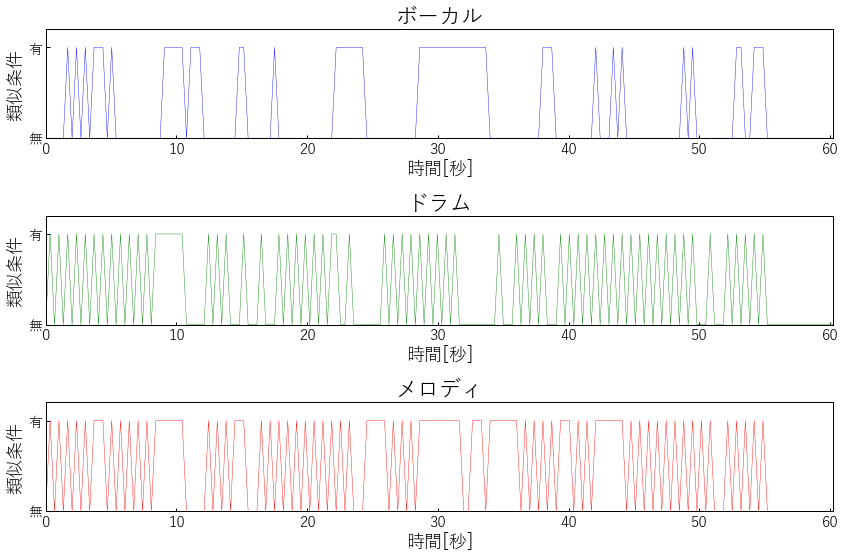

In [51]:
import numpy as np
import matplotlib.pyplot as plt
 
x1 = time_list

# UWW用
# y1 = del_body_part_vocals
# y2 = del_body_part_drums
# y3 = del_body_part_melodys

# y1 = body_part_vocals
# y2 = body_part_drums
# y3 = body_part_melodys

# y1 = data_to_boolint_vocals
# y2 = data_to_boolint_drums
# y3 = data_to_boolint_melodys

# y1 = compare_ideal_and_real_vocals
# y2 = compare_ideal_and_real_drums
# y3 = compare_ideal_and_real_melodys

y1 = ideal_vocals
y2 = ideal_drums
y3 = ideal_melodys
 
# plt.subplot(3,1,1)
# plt.plot(x,y1)
 
# plt.subplot(3,1,2)
# plt.plot(x,y2)

# plt.subplot(3,1,3)
# plt.plot(x,y3)
 
fig = plt.figure(figsize=(12, 8)) #...1

#図の形式定義
plt.rcParams['font.family'] ='Yu Gothic'#使用するフォント
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
plt.rcParams['font.size'] = 15 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ

label_l = ['', '無', '有']
# label_l = ['', 'real', 'ideal', '(0,0)', '(1,1)']
# label_l = ['', '合っていない', '(0,0)', '(1,1)']
# label_l = ['', 'メロディ', 'ドラム', 'ボーカル']

ax = fig.add_subplot(3, 1, 1)#(行，列，領域番号)
ax.plot(x1, y1,c="blue",linewidth=0.4)
# ax.plot(x1, y3,c="red",label='意識したパート',linewidth=0.4)
ax.set_xlabel('時間[秒]',fontsize=18)
ax.set_ylabel('類似条件',fontsize=18)
# ax.set_ylabel('合致度',fontsize=18)
# ax.set_ylabel('条件Sの発生回数[回]',fontsize=18)
# ax.set_yticks([-10,-5, 0,5, 10])
#     ax.set_ylabel('acc')
#     ax.set_xlim((0,14000))
ax.set_ylim((0, 1.2))
# ax.set_ylim((-2.2, 1.2))
ax.set_title("ボーカル",fontsize=22)
ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(1, -1))
ax.set_yticklabels(label_l, ha='right',fontsize=14)
# ax.legend(fontsize=15)
#     ax.show()

ax = fig.add_subplot(3, 1, 2)
ax.plot(x1, y2,c="green",linewidth=0.4)
# ax.plot(x1, y3,c="red",label='意識したパート',linewidth=0.4)
ax.set_xlabel('時間[秒]',fontsize=18)
ax.set_ylabel('類似条件',fontsize=18)
# ax.set_ylabel('合致度',fontsize=18)
# ax.set_ylabel('条件Sの発生回数[回]',fontsize=18)
#     ax.set_ylabel('ang')
#     ax.set_xlim((0,14000))
ax.set_title("ドラム",fontsize=22)
ax.set_ylim((0, 1.2))
# ax.set_ylim((-2.2, 1.2))
ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(1, -1))
ax.set_yticklabels(label_l, ha='right',fontsize=14)
# ax.legend(fontsize=15)

ax = fig.add_subplot(3, 1, 3)
ax.plot(x1, y3,c="red",linewidth=0.4)
# ax.plot(x1, y3,c="red",label='意識したパート',linewidth=0.4)
ax.set_xlabel('時間[秒]',fontsize=18)
#     ax.set_ylabel('ang')
#     ax.set_xlim((0,14000))
ax.set_title("メロディ",fontsize=22)
ax.set_ylabel('類似条件',fontsize=18)
# ax.set_ylabel('合致度',fontsize=18)
# ax.set_ylabel('条件Sの発生回数[回]',fontsize=18)
ax.set_ylim((0, 1.2))
# ax.set_ylim((-2.2, 1.2))
ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(1, -1))
ax.set_yticklabels(label_l, ha='right',fontsize=14)
# ax.legend(fontsize=15)

# figname = 'uww2021_dataA_2.pdf'
plt.tight_layout()    
    
# plt.show()

### Rulebase&tf/idf

In [11]:
rulebase_df = pd.DataFrame(
    {
        "alf":rulebase_accel_leftfoot,
        "arf":rulebase_accel_rightfoot,
        "alh":rulebase_accel_lefthand,
        "arh":rulebase_accel_righthand,
        "klf":rulebase_kinect_leftfoot,
        "krf":rulebase_kinect_rightfoot,
        "klh":rulebase_kinect_lefthand,
        "krh":rulebase_kinect_righthand
    }
)
# rulebase_df["alf"]
rule_melody_idf = (rulebase_df == 'メロディ').values.sum()
rule_drum_idf = (rulebase_df == 'ドラム').values.sum()
rule_vocal_idf = (rulebase_df == 'ボーカル').values.sum()
print(rule_melody_idf, rule_drum_idf, rule_vocal_idf)



312 219 594


In [28]:
i = 0
rule_tfidf_part = []
while i < len(rulebase_df)-7:
    rule_max_score_part = []
    rulebase_measure = rulebase_df[i:i+8]
    
    rule_melody_tf = (rulebase_measure == 'メロディ').values.sum()
    rule_drum_tf = (rulebase_measure == 'ドラム').values.sum()
    rule_vocal_tf = (rulebase_measure == 'ボーカル').values.sum()
#     print(rule_melody_tf, rule_drum_tf, rule_vocal_tf)

    rule_melody_tfidf = float(rule_melody_tf / rule_melody_idf)
    rule_drum_tfidf = float(rule_drum_tf / rule_drum_idf)
    rule_vocal_tfidf = float(rule_vocal_tf / rule_vocal_idf)
#     print(rule_melody_tfidf, rule_drum_tfidf, rule_vocal_tfidf)
    rule_max_score = max(rule_melody_tfidf, rule_drum_tfidf, rule_vocal_tfidf)
#     print(rule_max_score)
    if rule_max_score == 0:
        rule_max_score_part.append("なし")
    if rule_max_score == rule_vocal_tfidf:
        rule_max_score_part.append("ボーカル")
    if rule_max_score == rule_melody_tfidf:
        rule_max_score_part.append("メロディ")
    if rule_max_score == rule_drum_tfidf:
        rule_max_score_part.append("ドラム")

    rule_tfidf_part.append(rule_max_score_part)
    i += 8
print(rule_tfidf_part)
rule_tfidf_part_copy = rule_tfidf_part.copy()
del rule_tfidf_part_copy[23]
del rule_tfidf_part_copy[15]
del rule_tfidf_part_copy[7]
print(len(rule_tfidf_part_copy))
tf_idf_concious_part = make_concious_part(7, "two")
value_rule_tf_idf_concious_part = part_to_value(tf_idf_concious_part,tf_idf_concious_part)
enl_value_tf_idf_concious_part = enlarge_sentence(value_tf_idf_concious_part,100)
value_rule_tfidf_body_part = part_to_value(rule_tfidf_part_copy,tf_idf_concious_part)
enl_value_rule_tfidf_body_part = enlarge_sentence(value_rule_tfidf_body_part,100)

[['メロディ'], ['ドラム'], ['ボーカル'], ['ドラム'], ['ボーカル'], ['ボーカル'], ['ボーカル'], ['ドラム'], ['メロディ'], ['ボーカル'], ['ドラム'], ['ボーカル'], ['ボーカル'], ['ボーカル'], ['メロディ'], ['メロディ'], ['ドラム'], ['ドラム'], ['ドラム'], ['メロディ'], ['ボーカル'], ['メロディ'], ['メロディ'], ['ドラム']]
21


## to_csv

In [16]:
df = pd.DataFrame(
    {
        'time': halftime_list,
        'accel_leftfoot': enl_value_accel_leftfoot,
        'kinect_leftfoot': enl_value_kinect_leftfoot,
        'accel_lefthand': enl_value_accel_lefthand,
        'kinect_lefthand': enl_value_kinect_lefthand,
        'accel_rightfoot': enl_value_accel_rightfoot,
        'kinect_rightfoot': enl_value_kinect_rightfoot,
        'accel_righthand': enl_value_accel_righthand,     
        'kinect_righthand': enl_value_kinect_righthand,
        'value_concious_part' : enl_value_concious_part,
    }
)
df

NameError: name 'halftime_list' is not defined

## 図

In [14]:
def to_figure(rulebase_estimated_part,tfidf_estimated_part, concious_part):
    data_length = len(rulebase_estimated_part)
    figure_time_list = []
    for i in range(data_length):
        figure_time_list.append(i * 16 * quarter_count / 100)
#         figure_time_list.append(i * 16 * quarter_count / 100)
#     print(time_list)
#     df1 = df1.astype(float)
    x1 = figure_time_list
    y1 = rulebase_estimated_part
    y2 = tfidf_estimated_part
    y3 = concious_part


    # Figureの初期化
    fig = plt.figure(figsize=(12, 5)) #...1

    #図の形式定義
    plt.rcParams['font.family'] ='Yu Gothic'#使用するフォント
    plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
    plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
    plt.rcParams['font.size'] = 19 #フォントの大きさ
    plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ
    
    label_l = ['','drum', 'melody', 'vocal']
#     label_l = ['', '', 'drum', 'melody', 'vocal']
#     label_l = ['', 'melody', 'drum', 'vocal']

#     ax = fig.add_subplot(2, 1, 1)#(行，列，領域番号)
#     ax.plot(x1, y1,c="blue",label='Estimated Part',linewidth=0.8)
#     ax.plot(x1, y3,c="red",label='Conscious Part',linewidth=0.8)
#     ax.set_xlabel('Time[s]',fontsize=22)
# #     ax.set_ylabel('acc')
# #     ax.set_xlim((0,14000))
#     ax.set_ylim((0, 4.2))
#     ax.set_title("rule-based method",fontsize=26)
#     ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(1, -1))
#     ax.set_yticklabels(label_l, ha='right',fontsize=22)
#     ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=19)
#     ax.show()

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(x1, y2,c="green",label='Estimated Part',linewidth=0.8)
    ax.plot(x1, y3,c="red",label='Conscious Part',linewidth=0.8)
    ax.set_xlabel('Time[s]',fontsize=22)
#     ax.set_ylabel('ang')
#     ax.set_xlim((0,14000))
    ax.set_title("tf/idf method",fontsize=26)
    ax.set_ylim((0, 4.2))
    ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(1, -1))
    ax.set_yticklabels(label_l, ha='right',fontsize=22)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',fontsize=19)

    figname = 'uww2021_dataA_3.pdf'
    plt.tight_layout()#グラフが重ならず，設定した図のサイズ内に収まる。
    plt.savefig(figname)
#     files.download(figname)

In [16]:
# def to_figure_ruletfidf(rulebase_tfidf_estimated_part, concious_part):
#     data_length = len(rulebase_tfidf_estimated_part)
#     figure_time_list = []
#     for i in range(data_length):
#         figure_time_list.append(i * 8 * half_count / 100)
# #     print(time_list)
# #     df1 = df1.astype(float)
#     x1 = figure_time_list
#     y1 = rulebase_tfidf_estimated_part
#     y2 = concious_part


#     # Figureの初期化
#     fig = plt.figure(figsize=(12, 8)) #...1

#     #図の形式定義
#     plt.rcParams['font.family'] ='MS Gothic'#使用するフォント
#     plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
#     plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
#     plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
#     plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
#     plt.rcParams['font.size'] = 15 #フォントの大きさ
#     plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ
    
#     label_l = ['推定なし', 'メロディ', 'ドラム', 'ボーカル']

# #     ax = fig.add_subplot(2, 1, 1)#(行，列，領域番号)
#     plt.plot(x1, y1,c="blue",label='推定されたパート',linewidth=0.8)
#     plt.plot(x1, y2,c="red",label='意識したパート',linewidth=0.8)
#     plt.set_xlabel('時間[秒]',fontsize=18)
# #     ax.set_ylabel('acc')
# #     ax.set_xlim((0,14000))
#     plt.set_ylim((0, 4.2))
#     plt.set_title("ルールベース",fontsize=18)
#     plt.yaxis.set_major_locator(mpl.ticker.IndexLocator(1, -1))
#     plt.set_yticklabels(label_l, ha='right',fontsize=18)
#     plt.legend(fontsize=15)
#     plt.show()

# #     ax = fig.add_subplot(2, 1, 2)
# #     ax.plot(x1, y2,c="green",label='推定されたパート',linewidth=0.4)
# #     ax.plot(x1, y3,c="red",label='意識したパート',linewidth=0.4)
# #     ax.set_xlabel('時間[秒]',fontsize=18)
# # #     ax.set_ylabel('ang')
# # #     ax.set_xlim((0,14000))
# #     ax.set_title("tf-idf",fontsize=22)
# #     ax.set_ylim((0, 4.2))
# #     ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(1, -1))
# #     ax.set_yticklabels(label_l, ha='right',fontsize=18)
# #     ax.legend(fontsize=15)

#     figname = 'uww2021_dataA_3.pdf'
#     plt.tight_layout()#グラフが重ならず，設定した図のサイズ内に収まる。
#     plt.savefig(figname)
# #     files.download(figname)

# Check

In [ ]:
int_toshi_tf_idf
int_toshi_rule_base
uww2021_accuracy_data

In [26]:
enl_int_toshi_rule_base = enlarge_sentence(int_toshi_rule_base, 100)
enl_int_toshi_tf_idf = enlarge_sentence(int_toshi_tf_idf, 100)
enl_int_toshi_accuracy_data = enlarge_sentence(uww2021_accuracy_data, 100)
# enl_int_toshi_rule_base = enlarge_sentence(int_toshi_rule_base, 100)
# enl_int_toshi_tf_idf = enlarge_sentence(int_toshi_tf_idf, 100)
enl_int_toshi_accuracy_data = enlarge_sentence(int_toshi_accuracy_data, 100)
print(len(enl_int_toshi_accuracy_data))

NameError: name 'uww2021_accuracy_data' is not defined

In [12]:
value_rulebase_body_part=[1,2,3,2,1,3,1,1,3,1,3,1,3,1,1,1,2,1,1,1,1]
enl_value_rulebase_body_part = enlarge_sentence(value_rulebase_body_part,100)
len(enl_value_rulebase_body_part)

2100

In [13]:
check_concious_part = []
for _ in range(700):
    check_concious_part.append(1)
for _ in range(700):
    check_concious_part.append(2)
for _ in range(700):
    check_concious_part.append(3)

In [50]:
# enl_concious_part = make_concious_part(700, "two")
to_figure(enl_value_rulebase_body_part,enl_value_tfidf_body_part, check_concious_part)

NameError: name 'enl_value_rulebase_body_part' is not defined

In [61]:
rule_score = 0
for i, j in zip(uww2021_accuracy_data, int_toshi_rule_base):
# for i, j in zip(int_toshi_accuracy_data, int_toshi_rule_base):
    if i == j:
        rule_score += 1

rule_score = (rule_score / 23) * 100

tf_score = 0
for i, j in zip(uww2021_accuracy_data, int_toshi_tf_idf):
# for i, j in zip(int_toshi_accuracy_data, int_toshi_tf_idf):
    if i == j:
        tf_score += 1
        
tf_score = (tf_score / 23) * 100

print(rule_score, tf_score)

60.86956521739131 56.52173913043478


ValueError: x and y must have same first dimension, but have shapes (2000,) and (2300,)

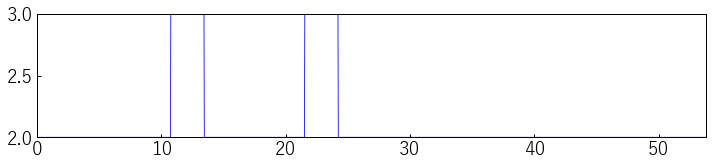

In [23]:
to_figure(enl_int_toshi_rule_base,
    enl_int_toshi_tf_idf,
    enl_int_toshi_accuracy_data)

In [272]:
Print_onset() #1/2拍

0 0 0
1 1 0
1 1 1
0 0 1
0 1 0
0 0 0
1 1 1
0 0 1
0 1 0
0 0 0
0 1 1
0 0 1
0 1 0
0 0 1
1 1 1
0 1 1
0 1 1
0 0 1
1 1 1
0 0 1
0 1 1
0 0 1
0 1 1
0 0 1
0 1 0
0 0 1
0 1 0
0 0 1
0 1 1
0 0 1
1 1 1
0 1 1
0 1 1
0 0 1
1 1 1
0 0 0
0 1 0
0 0 1
1 1 1
0 0 1
0 1 1
0 0 1
0 1 1
0 0 1
0 1 0
0 0 1
0 1 1
0 0 1
0 1 1
0 0 1
1 1 1
0 0 0
1 1 0
0 0 1
0 1 0
0 0 1
0 1 0
0 0 1
1 1 1
1 1 0
0 1 1
1 0 1
1 1 1
0 1 0
0 0 1
1 0 1
1 1 0
0 1 1
0 1 0
0 1 1
1 1 1
0 1 0
0 0 0
0 1 1
0 0 0
0 1 1
0 1 1
0 1 1
1 1 1
0 1 0
0 0 1
0 1 0
1 0 1
0 1 0
0 0 1
0 1 1
1 0 1
0 1 0
0 0 0
0 1 1
0 0 0
0 1 1
0 0 1
0 1 1
1 1 1
0 1 0
0 0 0
0 1 0
1 0 0
0 1 1
0 1 1
1 1 0
0 0 1
0 1 1
0 0 0
0 1 0
0 0 1
0 1 1
0 0 1
1 1 1
0 1 1
0 1 1
0 0 1
1 1 1
1 0 1
0 1 1
0 0 0
1 0 0
0 0 1
0 0 1
0 0 1
0 0 1
1 1 0
1 1 0
0 1 0
1 1 1
0 1 1
0 1 1
0 0 1
1 1 1
0 1 1
0 1 0
1 0 0
0 1 0
1 0 1
0 1 0
1 0 1
1 1 0
0 0 1
0 1 0
0 1 0
0 1 1
0 1 1
0 1 1
0 1 1
1 1 0
0 0 1
0 1 0
0 0 0
0 1 0
0 0 1
0 1 1
0 0 1
1 1 1
0 0 1
1 1 1
0 0 1
1 0 0
0 0 0
1 1 0
0 0 0
1 1 0
0 1 1
0 1 1
1 1 0
0 0 0
0 1 

In [221]:
Print_move() #1/2拍

加右手 加右足 加左手 加左足 間右手 間右足 間左手 間左足
0 0 0 0 0 0 0 0
0 1 0 1 1 1 1 1
0 0 0 0 1 1 1 1
1 1 1 1 1 1 1 0
0 0 0 1 1 1 1 1
0 1 1 0 1 1 1 0
1 1 1 1 1 1 1 1
1 1 0 1 1 0 1 1
1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1
0 1 0 0 1 1 1 0
1 1 0 0 1 1 1 1
1 0 1 0 1 1 1 1
0 0 1 1 1 1 1 1
0 0 0 1 1 1 1 1
1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1
0 1 0 0 1 1 0 1
0 1 0 0 1 1 0 1
1 1 1 0 1 1 1 1
1 0 0 1 1 1 1 0
1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1
1 1 1 0 1 1 1 0
1 1 0 1 1 1 1 1
0 0 1 1 1 0 1 1
0 0 1 1 0 1 1 1
1 1 1 1 1 1 0 1
0 1 1 0 1 0 1 1
1 1 0 1 1 1 1 1
0 1 0 0 1 1 1 1
1 1 1 1 1 1 1 1
1 0 1 1 0 0 1 0
0 1 0 1 1 0 1 1
0 0 0 0 1 1 1 1
1 1 1 1 1 1 0 1
0 0 1 0 1 1 1 1
1 1 1 1 1 1 1 0
1 1 1 0 1 0 1 1
1 1 0 0 1 1 0 1
1 0 1 0 1 1 1 1
1 1 1 0 1 1 1 1
0 0 0 0 1 0 1 0
1 1 1 1 1 1 1 1
0 0 0 1 1 1 1 1
0 0 0 1 1 0 1 1
0 0 0 1 1 0 0 1
1 0 1 1 1 1 1 1
1 1 0 1 1 1 0 1
1 0 1 1 1 1 1 1
1 0 1 1 1 1 1 0
0 0 0 1 1 1 1 1
0 0 0 1 1 1 1 1
1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1
1 1 0 1 1 1 1 1
1 1 1 1 1 0 1 1
0 0 0 0 1 0 1 1
0 0 0 0 1 1 1 1
0 0 0 0 

In [187]:
Print_move() #1/4拍

加右手 加右足 加左手 加左足 間右手 間右足 間左手 間左足
0 0 0 0 0 0 0 0
0 0 1 0 1 0 1 0
0 1 0 1 0 1 1 0
0 1 0 1 1 1 1 1
0 0 0 0 1 1 0 1
0 0 0 0 1 1 1 1
0 0 0 1 1 1 1 0
1 1 1 0 1 1 0 0
0 0 0 0 1 1 1 0
0 0 0 1 1 0 0 1
0 1 0 0 1 0 1 0
0 1 1 0 0 1 1 0
1 1 1 1 1 0 1 1
1 1 1 1 1 1 0 0
1 1 0 1 0 0 1 1
1 0 0 1 1 0 0 1
1 1 1 1 1 0 1 0
0 1 1 0 1 1 0 0
0 1 0 0 1 0 1 1
0 1 1 1 1 1 1 1
0 1 0 0 0 1 1 0
0 0 0 0 1 1 1 0
0 0 0 0 1 1 1 0
1 1 0 0 0 1 0 1
1 0 1 0 0 1 1 1
0 0 0 0 1 1 0 0
0 0 0 1 1 0 1 1
0 0 1 0 1 1 1 1
0 0 0 1 0 0 1 0
0 0 0 0 1 1 1 1
0 0 0 0 0 0 1 1
1 1 1 1 1 1 1 1
0 1 1 1 1 1 0 1
1 1 1 0 1 0 1 1
0 1 0 0 0 1 0 1
0 1 0 0 1 0 0 1
0 1 0 0 1 0 0 1
0 0 0 0 1 1 0 0
0 0 0 0 1 1 1 0
1 1 1 0 1 1 1 1
1 0 0 1 1 0 0 0
1 0 0 1 0 1 1 0
1 1 0 0 1 0 0 1
1 0 1 1 0 1 1 1
1 1 1 1 1 1 1 0
0 1 0 1 1 0 0 1
0 1 0 0 1 1 0 0
1 1 1 0 1 1 1 0
1 1 0 1 0 0 1 1
0 0 0 1 1 1 1 0
0 0 0 1 0 0 1 1
0 0 1 0 1 0 1 0
0 0 1 1 0 0 0 0
0 0 0 0 0 1 1 1
1 1 0 1 0 1 0 0
0 1 1 0 1 0 0 1
0 0 1 0 0 0 1 1
0 1 0 0 1 0 0 0
1 1 0 1 1 1 0 1
0 0 0 0 1 0 1 1
0 1 0 0 

In [220]:
Print_onset() #1/2拍

0 0 0
1 1 0
1 1 1
0 0 1
0 1 0
0 0 0
1 1 1
0 0 1
0 1 0
0 0 0
0 1 1
0 0 1
0 1 0
0 0 1
1 1 1
0 1 1
0 1 1
0 0 1
1 1 1
0 0 1
0 1 1
0 0 1
0 1 1
0 0 1
0 1 0
0 0 1
0 1 0
0 0 1
0 1 1
0 0 1
1 1 1
0 1 1
0 1 1
0 0 1
1 1 1
0 0 0
0 1 0
0 0 1
1 1 1
0 0 1
0 1 1
0 0 1
0 1 1
0 0 1
0 1 0
0 0 1
0 1 1
0 0 1
0 1 1
0 0 1
1 1 1
0 0 0
1 1 0
0 0 1
0 1 0
0 0 1
0 1 0
0 0 1
1 1 1
1 1 0
0 1 1
1 0 1
1 1 1
0 1 0
0 0 1
1 0 1
1 1 0
0 1 1
0 1 0
0 1 1
1 1 1
0 1 0
0 0 0
0 1 1
0 0 0
0 1 1
0 1 1
0 1 1
1 1 1
0 1 0
0 0 1
0 1 0
1 0 1
0 1 0
0 0 1
0 1 1
1 0 1
0 1 0
0 0 0
0 1 1
0 0 0
0 1 1
0 0 1
0 1 1
1 1 1
0 1 0
0 0 0
0 1 0
1 0 0
0 1 1
0 1 1
1 1 0
0 0 1
0 1 1
0 0 0
0 1 0
0 0 1
0 1 1
0 0 1
1 1 1
0 1 1
0 1 1
0 0 1
1 1 1
1 0 1
0 1 1
0 0 0
1 0 0
0 0 1
0 0 1
0 0 1
0 0 1
1 1 0
1 1 0
0 1 0
1 1 1
0 1 1
0 1 1
0 0 1
1 1 1
0 1 1
0 1 0
1 0 0
0 1 0
1 0 1
0 1 0
1 0 1
1 1 0
0 0 1
0 1 0
0 1 0
0 1 1
0 1 1
0 1 1
0 1 1
1 1 0
0 0 1
0 1 0
0 0 0
0 1 0
0 0 1
0 1 1
0 0 1
1 1 1
0 0 1
1 1 1
0 0 1
1 0 0
0 0 0
1 1 0
0 0 0
1 1 0
0 1 1
0 1 1
1 1 0
0 0 0
0 1 

In [184]:
Print_onset() #1/4拍

0 0 0
0 1 0
1 1 0
0 0 0
1 1 0
0 0 1
0 0 1
0 0 1
0 0 0
0 1 0
0 0 0
0 0 0
0 0 1
1 1 0
0 0 0
0 0 1
0 0 0
0 1 0
0 0 0
0 0 0
0 0 1
0 1 0
0 0 1
0 0 0
0 0 0
0 1 0
0 0 1
0 0 1
0 1 1
1 1 1
0 1 1
0 1 0
0 1 0
0 1 1
0 0 0
0 0 1
0 0 1
1 1 0
0 0 1
0 0 0
0 1 1
0 1 0
0 0 0
0 0 1
0 1 0
0 1 1
0 0 0
0 0 1
0 1 0
0 1 0
0 0 1
0 0 0
0 1 0
0 0 0
0 0 1
0 0 1
0 1 0
0 0 1
0 0 0
0 0 1
0 1 0
1 0 1
0 1 1
0 0 0
0 1 1
0 0 1
0 0 1
0 0 1
1 1 0
1 0 1
0 0 0
0 0 0
0 1 0
0 1 0
0 0 0
0 0 1
1 1 1
0 0 0
0 0 1
0 0 0
0 1 1
0 0 0
0 0 1
0 0 0
0 1 0
0 0 1
0 0 1
0 0 0
0 1 0
0 0 0
0 0 1
0 0 1
0 1 1
0 1 0
0 0 1
0 0 0
0 1 0
0 0 1
0 0 1
0 0 1
1 1 1
1 0 0
0 0 0
0 0 0
0 1 0
1 0 0
0 0 0
0 0 1
0 1 0
0 0 0
0 0 1
0 0 0
0 1 0
0 0 0
0 0 1
0 0 0
0 1 1
1 0 0
0 0 0
1 1 0
0 0 1
0 1 0
0 0 1
1 0 0
0 1 1
1 1 0
0 1 0
0 1 0
0 0 1
0 0 0
0 0 1
1 0 0
1 1 0
1 1 0
0 0 1
0 1 0
0 1 0
0 0 0
0 0 0
0 1 1
0 1 1
1 0 0
0 0 0
0 1 0
0 0 0
0 0 0
0 0 1
0 1 0
0 0 0
0 0 0
0 0 1
0 1 0
0 0 1
0 1 1
0 0 1
0 1 0
1 0 0
0 1 1
0 0 0
0 1 0
0 0 1
0 0 0
0 0 0
0 1 0
0 0 0
1 0 1
0 0 

In [188]:
Print_similarly() #klf, krf, klh, krh, alf, arf, alh, arh

TypeError: Print_similarly() missing 1 required positional argument: 'number'

In [77]:
point = 100
level = 50
def find_valid_point(level, point: int) -> int:
    for i in range(point):
        if level * i >= 100 and i <= point/2:
            valid_point = i
            return valid_point
        else:
            return point



upgrade(50,100)

100

In [79]:
upgrade_level = level
while point > 0:
    valid_point = find_valid_point(upgrade_level, point)
    upgrade_level = upgrade(upgrade_level, valid_point)
    point -= valid_point
print(upgrade_level)

100


In [126]:
l = 5000
# for _ in range(1):
#     l = upgrade(l, 2)
for _ in range(100):
    l= upgrade(l, 1)    
print(l)

13438


In [167]:
point = 3
level = 10000

def upgrade(current_level: int, use_point: int) -> int:
    upgrade_level = int(current_level + current_level * use_point / 100)
    return upgrade_level

def calculate_point(level, point):
    
    point_lists = list(range(1, point+1))
    times = [int(point / n) for n in point_lists]
    lefts = [point % n for n in point_lists]
    level_list = []
    for point_list,time,left in zip(point_lists, times, lefts):
        upgrade_level = level
        print(point_list, time, left)
        for _ in range(time):
            upgrade_level = upgrade(upgrade_level, point_list)
        if left > 0:
            for _ in range(1,left+1):
                add_level_1 = upgrade(upgrade_level, 1)
            add_level_2 = upgrade(upgrade_level, left)
            add_level = max(add_level_1, add_level_2)
            upgrade_level = add_level
        level_list.append(upgrade_level)
    return max(level_list)
a = calculate_point(level, point)
print(a)

1 3 0
2 1 1
3 1 0
10303
